# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import string
import time
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import gensim

import nltk
from nltk.tokenize import word_tokenize

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.pipeline import Pipeline

from joblib import dump, load

from gensim import corpora, models
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.phrases import Phrases, Phraser

import ast

# Get Data

In [ ]:
data = pd.read_csv('datasetv2.csv')
data

# EDA

## Explore Data

In [ ]:
data.columns

In [ ]:
data.shape

In [ ]:
data.info()

menghitung total nilai yang null

In [ ]:
print("Jumlah missing values:\n", data.isnull().sum())

visualisasi distribusi data

In [ ]:
rating_counts = data['rating'].value_counts().sort_index()

plt.figure(figsize=(7, 4))
bars = plt.bar(rating_counts.index, rating_counts.values, color='skyblue')
plt.xlabel("Rating")
plt.ylabel("Jumlah")
plt.title("Distribusi Rating Ulasan Sunscreen Merek Lokal")
plt.xticks(rating_counts.index)  # Mengatur label pada sumbu x

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, str(yval), ha='center', va='bottom')

plt.show()

melakukan pengecekan apakah ada data yang sama, melakukan perhitungan jumlah ulasan yang duplikasi dan selanjutnya hapus duplikasi ulasan

In [ ]:
data.duplicated().sum()

In [9]:
data.drop_duplicates(inplace=True)

In [ ]:
data.duplicated().sum()

sebelum melakukan penghapusan duplikasi data berjumlah 1988, setelah melakukan penghapusan jumlah data yaitu 1988-600=1388

In [ ]:
data.shape[0]

In [ ]:
data.head()

simpan file data yang sudah diseleksi, yang kemudian data akan melalui tahapan labeling secara manual

In [13]:
# Simpan ke file CSV baru
data.to_csv('hasil/selected_new.csv', index=False)

## Labeled Data

In [ ]:
df = pd.read_csv("hasil\labeled_data.csv")
df.head()

In [ ]:
print("Jumlah missing values:\n", df.isnull().sum())

Dari proses pelabelan, didapatkan jumlah data pada masing-masing label yaitu sebagai berikut:

In [ ]:
label_counts = df['label'].value_counts().sort_index()

plt.figure(figsize=(6, 5))
colors = ['#3B4CC0', '#6486D1', '#AFC8E7', '#F4A582', '#B2182B']
bars = plt.bar(label_counts.index, label_counts.values, color=colors)

ax = plt.gca()
ax.bar_label(bars, fmt='%d', label_type='edge', fontsize=8, padding=3)

plt.xlabel("Label")
plt.ylabel("Jumlah")
plt.title("Distribusi Label Ulasan Sunscreen Merek Lokal")
plt.xticks(label_counts.index)

plt.show()


Distribusi ulasan positif dan negatif berdasarkan rating

In [ ]:
distribusi = df.groupby(['rating', 'label']).size().unstack(fill_value=0)

ax = distribusi.plot(kind='bar', colormap='coolwarm', figsize=(10,4)) # membuat plot grouped bar chart
for container in ax.containers: # menambahkan label pada setiap bar
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=8, padding=3)

# label dan judul
plt.xlabel('Rating')
plt.ylabel('Jumlah Ulasan')
plt.title('Distribusi Ulasan Positif dan Negatif Berdasarkan Rating')
plt.legend(['Negatif', 'Positif'], title='Label')

plt.show()


# Pre-processing Data

## Case Folding

mengubah kapital menjadi huruf kecil

In [2]:
def lowercasing_text(text):
    text = text.lower() # convert into lower case
    return text

In [ ]:
df['lowercased_text'] = df['text_content'].apply(lowercasing_text)
pd.options.display.max_colwidth = 200
df.head()

In [20]:
# Simpan ke file excel baru
df.to_excel('hasil/lowercased_new.xlsx', index=False)

## Normalization

tahapan ini yaitu melakukan normalisasi pada kata singkat dan tidak baku, untuk daftar kata dibuat sendiri setelah melakukan pengamatan pada dataset, yang kemudian disimpan dalam file word_correction.txt

In [ ]:
def load_correction_text(file_path):
    correction_dict = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split(':')
            if len(parts) == 2:
                correction_dict[parts[0].strip()] = parts[1].strip()
    return correction_dict

def normalize_text(text, correction_dict):    
    if not isinstance(text, str):
        return text  

    pattern = re.compile(r'\b(' + '|'.join(re.escape(k) for k in correction_dict.keys()) + r')\b')    
    normalized_text = pattern.sub(lambda x: correction_dict.get(x.group(), x.group()), text)
    
    return normalized_text

correction_dict = load_correction_text('dictionary\word_correction.txt')

In [ ]:
df['normalized_text'] = df['lowercased_text'].apply(lambda x: normalize_text(x, correction_dict))

hasil_normalisasi = df[['lowercased_text', 'normalized_text']]
pd.options.display.max_colwidth = 600
hasil_normalisasi.head(1)

In [23]:
df.to_excel('hasil/normalized_new.xlsx', index=False) #simpan hasil lowercase dan normalisasi

## Filtering

teks yang sudah melalui tahapan normalisasi selanjutnya akan dilakukan pembersihan karakter-karakter tidak penting (tagar, angka, @username, dll) serta stopwords yang tidak dibutuhkan untuk proses klasifikasi

### remove karakter

In [47]:
def cleaning_text(text):
        
    text = re.sub(r'[@#]\w+', ' ', text)  # Menghapus mention (@username) dan tagar (#hashtag)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)  # Menghapus karakter non-alfabet dan angka dan ganti menjadi spasi
    text = re.sub(r'\s+', ' ', text).strip()  # Menghapus spasi berlebih

    return text

In [25]:
df['filtered_text'] = df['normalized_text'].apply(cleaning_text)

In [ ]:
hasil_cleaning = df[['normalized_text', 'filtered_text']]
pd.options.display.max_colwidth = 600
hasil_cleaning.head(1)

In [ ]:
df.iloc[100]["filtered_text"]

In [28]:
df.to_excel('hasil/cleaning_new.xlsx', index=False) ## Simpan ke file excel baru

### stopwords

daftar stopwords didapatkan dari library Sastrawi serta membuat daftar stopwords secara mandiri, dua daftar ini kemudian akan digabungkan untuk memperkaya list stopwords yang perlu dihapus.

In [ ]:
# mengambil daftar stopwords bawaan dari lib sastrawi
stopword_factory = StopWordRemoverFactory() 
stopwords = set(stopword_factory.get_stop_words())

# menyimpan daftar stopwords sastrawi dalam file json
with open("dictionary\default_stopwords.json", "w") as file:
    json.dump(sorted(stopwords), file, indent=4)

print(sorted(stopwords))

gabungkan file stopwords sastrawi dengan banned_words.txt

In [ ]:
# load stopwords tambahan dari file banned_words.txt
additional_stopwords = set()
with open("dictionary/banned_words.txt", "r", encoding="utf-8") as file:
    additional_stopwords.update(word.strip().lower() for word in file if word.strip())

# menggabungkan stopwords bawaan dengan stopwords tambahan (hapus duplikat)
stopwords.update(additional_stopwords)

# menyimpan daftar stopwords ke file JSON
with open("dictionary/stopwords_klasifikasi.json", "w", encoding="utf-8") as file:
    json.dump(sorted(stopwords), file, indent=4, ensure_ascii=False)

print("Daftar stopwords telah disimpan dalam stopwords.json")
print(sorted(stopwords))

mengedit daftar stopwords yang telah digabungkan

In [ ]:
# menghapus word pada stopwords
def remove_words(words):
    removed_words = [word for word in words if word in stopwords]
    stopwords.difference_update(words)
    print(f"Kata-kata berikut telah dihapus dari daftar stopwords: {', '.join(removed_words)}")

# penghapusan beberapa kata pada stopwords
remove_words(["apalagi", "bagaimanapun", "belum", "boleh", "dalam", "daripada", "dimana", "hanya", "harus", "ingin",
              "ketika", "lagi", "masih", "pasti", "sampai", "sebelum", "seharusnya", "sesudah", "setelah", "selain", 
              "selagi", "setiap", "setidaknya", "supaya", "tanpa", "tapi", "tetapi", "tidak", "tolong"])

# menyimpan daftar stopwords ke file JSON setelah melakukan penghapusan dengan nama stopwords_update.json
with open("dictionary/stopwords_klasifikasi.json", "w", encoding="utf-8") as file:
    json.dump(sorted(stopwords), file, indent=4, ensure_ascii=False)

print(sorted(stopwords))

In [51]:
def remove_stopwords(text):    
    words = text.split()  # Pisahkan kata-kata dalam teks
    cleaned_words = [word for word in words if word.lower() not in stopwords]  # Hapus stopwords
    return " ".join(cleaned_words)  # Gabungkan kembali kata-kata yang tersisa

In [33]:
df['filtered_text'] = df['filtered_text'].apply(remove_stopwords)

In [ ]:
hasil_removestopwords = df[['normalized_text', 'filtered_text']]
pd.options.display.max_colwidth = 600
hasil_removestopwords.head(1)

In [ ]:
df.iloc[1000]["filtered_text"]

In [36]:
df.to_excel('hasil/stopwords_new.xlsx', index=False) 
df.to_csv('hasil/filtered_new.csv', index=False)

## Tokenizing

tokenizing, mengurai kalimat menjadi kata atau token

In [52]:
def tokenizing_text(text):
    text = word_tokenize(text)
    return text

In [38]:
df['tokens'] = df['filtered_text'].apply(tokenizing_text)

In [ ]:
hasil_tokenisasi = df[['filtered_text', 'tokens']]
pd.options.display.max_colwidth = 600
hasil_tokenisasi.head(1)

In [40]:
# df.to_csv('hasil/tokenized_text.csv', index=False)
# df.to_excel('hasil/tokenisasi_new.xlsx', index=False)

## Stemming

stemming, menghapus inmbuhan pada kata dan mengubahnya menjadi bentuk pertama (dasar). pada tahap ini memanfaatkan library Sastrawi

In [53]:
def stemming_text(tokens):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return [stemmer.stem(word) for word in tokens]

In [42]:
df['stemmed_text'] = df['tokens'].apply(stemming_text)

In [ ]:
hasil_stemming = df[['tokens', 'stemmed_text']]
pd.options.display.max_colwidth = 600
hasil_stemming.head(1)

ini buat dokumentasi

In [44]:
# df.to_excel('hasil/stemming.xlsx', index=False)
# df.to_csv('hasil/cleaned_data.csv', index=False)

In [54]:
# fungsi stemming buat untuk pipeline

def stemming(tokens):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed_tokens)  # Kembalikan string

# Classification

In [ ]:
dataset = pd.read_csv('hasil/cleaned_data.csv')
dataset.head()

## Prep Data

### annotate data

untuk label positif akan diubah menjadi 1 sedangkan negatif diubah menjadi -1

In [ ]:
dataset.label.replace(['negatif','positif'], [-1,1], inplace=True)
dataset.head(2)

In [ ]:
dataset['label'].value_counts()

In [ ]:
dataset.columns

In [ ]:
dataset = dataset[['stemmed_text', 'label']]
dataset.head(1)

menyeimbangkan antara data negatif dan positif, hal ini dilakukan agar tidak terjadi bias terhadap kelas yang memiliki lebih banyak data saat melakukan training model

In [ ]:
print("Jumlah data berlabel positif sebelum drop:", dataset["label"].value_counts()[1])
print("Jumlah data berlabel negatif sebelum drop:", dataset["label"].value_counts()[-1])

In [9]:
dataset = dataset.drop(dataset[dataset.label == 1].index[:100])

In [ ]:
print("Jumlah data berlabel positif setelah drop:", dataset["label"].value_counts()[1])
print("Jumlah data berlabel negatif setelah drop:", dataset["label"].value_counts()[-1])

### split data

memisahkan fitur (X) dan target (y)

In [11]:
X = dataset.stemmed_text
y = dataset.label

membagi data training dan data testing dengan perbandingan 80:20

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# tampilkan hasil pembagian
print(f"Jumlah data training: {len(X_train)}")
print(f"Jumlah data testing: {len(X_test)}")

In [ ]:
print("jumlah label di data training:\n", y_train.value_counts())
print("jumlah label di data testing", y_test.value_counts())

### TF-IDF

melakukan pembobotan pada kata dengan TF-IDF, hal ini bertujuan untuk memberikan bobot yang lebih besar pada kata yang sering muncul dalam satu dokumen (ulasan) tetapi jarang muncul di dokumen lain.

In [ ]:
vectoriser = TfidfVectorizer()
X_train_tfidf = vectoriser.fit_transform(X_train) # fit dan transform hanya pada x_train
X_test_tfidf= vectoriser.transform(X_test) # transform x_test menggunakan vektor dari x_train

# Menampilkan jumlah fitur yang dihasilkan
print(f"Jumlah fitur TF-IDF: {len(vectoriser.get_feature_names_out())}")

In [ ]:
# # konversi TF-IDF matrix ke DataFrame
# df_tfidf_train = pd.DataFrame(X_train_tfidf.toarray(), columns=vectoriser.get_feature_names_out())
# df_tfidf_test = pd.DataFrame(X_test_tfidf.toarray(), columns=vectoriser.get_feature_names_out())

# # simpan ke excel
# df_tfidf_train.to_excel("0603/tfidf_train.xlsx", index=False)
# df_tfidf_test.to_excel("0603/tfidf_test.xlsx", index=False)

In [ ]:
from sklearn.model_selection import GridSearchCV
svm = SVC(kernel='rbf')

# Buat parameter grid untuk dicari
param_grid = {
    'C': [1, 1.25, 1.50, 1.75, 2],    # Rentang nilai C
    'gamma': [0.2, 0.4, 0.6, 0.8] # Rentang nilai gamma
}

grid_search = GridSearchCV(svm, param_grid, cv=10, scoring='accuracy', n_jobs=-1, return_train_score=True) # Inisialisasi GridSearchCV
grid_search.fit(X_train_tfidf, y_train) # Latih model dengan GridSearchCV


print("\nCross-Validation Results:")
print(pd.DataFrame(grid_search.cv_results_)[['param_C', 'param_gamma', 'mean_test_score', 'std_test_score', 'mean_train_score']].sort_values(by='mean_test_score', ascending=False))
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Accuracy: {grid_search.best_score_:.4f}")

In [ ]:
# Latih ulang model dengan seluruh data latih
best_svm = SVC(kernel='rbf', C=grid_search.best_params_['C'], gamma=grid_search.best_params_['gamma'])
best_svm.fit(X_train_tfidf, y_train)

# Evaluasi performa model terbaik
y_tes_pred = best_svm.predict(X_test_tfidf)

akurasi = accuracy_score(y_test, y_tes_pred)
laporan = classification_report(y_test, y_tes_pred)

print(f"\nFinal Model Test Accuracy: {akurasi:}")
print("Classification Report:\n", laporan)

## Training Model

In [ ]:
svm = SVC(kernel='rbf', C=1, gamma=0.2) # inisialisasi model svm dengan kernel rbf
svm.fit(X_train_tfidf, y_train) # latih model dengan data x dan y

In [ ]:
y_pred = svm.predict(X_test_tfidf) # prediksi data text (X_test)

accuracy = accuracy_score(y_test, y_pred) # evaluasi performa model pada data uji
report = classification_report(y_test, y_pred)

print(f"\nFinal Model Test Accuracy without CV: {accuracy:.4f}")
print("Classification Report:\n", report)

## Evaluasi Model

In [ ]:
y_pred = svm.predict(X_test_tfidf) # prediksi data text (X_test)

accuracy = accuracy_score(y_test, y_pred) # evaluasi performa model pada data uji
report = classification_report(y_test, y_pred)

print(f"\nFinal Model Test Accuracy without CV: {accuracy:.4f}")
print("Classification Report:\n", report)

# Pipeline Preprocessing dan Classification SVM

load dataset kotor yang sudah ada label (tidak ada data duplikat)

In [ ]:
df = pd.read_csv("hasil\labeled_data.csv")
df.head()

In [ ]:
df.columns

cek duplikat

In [ ]:
df.duplicated().sum()

annonate data

In [ ]:
df.label.replace(['negatif','positif'], [-1,1], inplace=True)
df.head(2)

In [68]:
df.to_csv('hasil/anonate_data.csv', index=False)

In [ ]:
df['label'].value_counts()

drop data untuk menyeimbangkan

In [ ]:
print("Jumlah data berlabel positif sebelum drop:", df["label"].value_counts()[1])
print("Jumlah data berlabel negatif sebelum drop:", df["label"].value_counts()[-1])

In [71]:
# menghapus data label yang bernilai 1, perbedaan data label neg dan pos tidak lebih dari 10%
df = df.drop(df[df['label'] == 1].index[:100])

In [ ]:
print("Jumlah data berlabel positif setelah drop:", df["label"].value_counts()[1])
print("Jumlah data berlabel negatif setelah drop:", df["label"].value_counts()[-1])

tentukan fitur dan target

percobaan make file anonate_data

In [73]:
X = df.text_content
y = df.label

split data dengan ketentuan 80:20

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# tampilkan hasil pembagian
print(f"Jumlah data training: {len(X_train)}")
print(f"Jumlah data testing: {len(X_test)}")

In [ ]:
print("jumlah label di data training:\n", y_train.value_counts())
print("jumlah label di data testing", y_test.value_counts())

gabungkan semua fungsi preprocessing

In [ ]:
# Definisikan fungsi preprocessing gabungan
def text_preprocessing(text):
    correction_dict = load_correction_text('dictionary\word_correction.txt')
    
    text = lowercasing_text(text)
    text = normalize_text(text, correction_dict)
    text = cleaning_text(text)
    text = remove_stopwords(text)
    tokens = tokenizing_text(text) # hasilnya berupa token
    text = stemming(tokens) # hasilnya nanti jadi string lagi
    return text # output berupa string

buat pipeline dari preprocessing sampai klasifikasi

In [77]:
svm = SVC(kernel='rbf', C=1, gamma=0.2) # inisialisasi model svm dengan kernel rbf

In [78]:
# membuat pipeline
svm_pipeline = Pipeline([
    ('preprocess', TfidfVectorizer(preprocessor=text_preprocessing)),
    ('svm', svm)
])

training model

In [ ]:
# Latih model
svm_pipeline.fit(X_train, y_train)

evaluasi model

In [ ]:
# Evaluasi
y_pred = svm_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) # evaluasi performa model pada data uji

print(f"\nTest Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

In [ ]:
# menghitung confusion matrix
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cm)

# visualisasi confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix")
plt.show()

save model

In [ ]:
dump(svm_pipeline, 'revisi/svm_model_0903.joblib')

# Predict Label Dataset

In [13]:
# Memuat model kembali
svm_loaded = load('revisi/svm_model_0903.joblib')

In [ ]:
# Baca file CSV (ganti dengan path file CSV kamu)
data = pd.read_csv('revisi/dataset1003.csv')
data.head()

In [ ]:
data.shape

In [16]:
# teks ulasan yang diprediksi berada pada kolom text_content
texts = data.text_content

In [17]:
# prediksi sentimen
predictions = svm_loaded.predict(texts)

# tambahkan hasil prediksi ke DataFrame
data['label'] = predictions

In [ ]:
data.head()

In [ ]:
data.label.value_counts()

In [ ]:
data.to_excel('revisi\predict1003.xlsx', index=False)
data.to_csv('revisi\predict1003.csv', index=False)

In [ ]:
data = ["telah pakai produk ikut rasa whitecast sangat pedih mata buat muka minyak padahal tipe muka "
"normal kombinasi terus buat muka jadi kusam telah pakai terus efek panas kulit"]
prediction = svm_loaded.predict(data)

# hasil prediksi dengan label yang sesuai
label = "Positif" if prediction[0] == 1 else "Negatif" if prediction[0] == -1 else "Tidak Diketahui"
print("Hasil prediksi sentimen:", label)

# Topic Modeling

In [ ]:
data = pd.read_csv('revisi/predict1003.csv')
data.label.value_counts()

valid predict merupakan data hasil prediksi yang telah divalidasi oleh pakar

In [2]:
df = pd.read_csv('revisi/predict1003_age.csv')
df.head()

age kategori_usia  rating  \
0  19 - 24        Remaja       5   
1  19 - 24        Remaja       5   
2  19 - 24        Remaja       4   
3  30 - 34  Dewasa Akhir       4   
4  25 - 29   Dewasa Awal       3   

                                        text_content  label  
0  Aku punya yang packaging nya mungil ( travel s...      1  
1  THIS IS ONE OF THE BEST & UNDERRATED SUNSCREEN...     -1  
2  Cepet ngeresap dan gampang diblend ga bikin mu...      1  
3  Teksturnya ringan, mudah diratakan, dan cepat ...      1  
4  Ini aku salah beli deh, ternyata lebih cocok u...     -1

In [3]:
df.label.value_counts()

label
-1    673
 1    620
Name: count, dtype: int64

In [4]:
post_text = df[df['label'] == 1]
post_text.head(2)

age kategori_usia  rating  \
0  19 - 24        Remaja       5   
2  19 - 24        Remaja       4   

                                        text_content  label  
0  Aku punya yang packaging nya mungil ( travel s...      1  
2  Cepet ngeresap dan gampang diblend ga bikin mu...      1

In [5]:
neg_text = df[df['label'] == -1]
neg_text.head(2)

age kategori_usia  rating  \
1  19 - 24        Remaja       5   
4  25 - 29   Dewasa Awal       3   

                                        text_content  label  
1  THIS IS ONE OF THE BEST & UNDERRATED SUNSCREEN...     -1  
4  Ini aku salah beli deh, ternyata lebih cocok u...     -1

In [25]:
# neg_text.to_csv('hasil/topicmodel_dataset.csv', index=False)
neg_text.to_excel('negatif1003.xlsx', index=False)

## Cleaning Text

fungsi praproses

In [48]:
# case folding
def lowercasing_text(text):
    text = text.lower() # convert into lower case
    return text # hasil lowercase disimpan dalam variabel text

# normalisasi
def load_correction_text(file_path):
    correction_dict = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split(':')
            if len(parts) == 2:
                correction_dict[parts[0].strip()] = parts[1].strip()
    return correction_dict

def normalize_text(text, correction_dict):    
    if not isinstance(text, str):
        return text  
    pattern = re.compile(r'\b(' + '|'.join(re.escape(k) for k in correction_dict.keys()) + r')\b')    
    normalized_text = pattern.sub(lambda x: correction_dict.get(x.group(), x.group()), text)    
    return normalized_text # hasil normalisasi disimpan dalam variabel normalized_text

# filtering
def cleaning_text(text):        
    text = re.sub(r'[@#]\w+', ' ', text)  # Menghapus mention (@username) dan tagar (#hashtag)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)  # Menghapus karakter non-alfabet dan angka dan ganti menjadi spasi
    text = re.sub(r'\s+', ' ', text).strip()  # Menghapus spasi berlebih
    return text # hasil filtering disimpan dalam text   

# tokenizing
def tokenizing_text(text):
    text = word_tokenize(text)
    return text

# stemming
def stemming_text(tokens):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return [stemmer.stem(word) for word in tokens]

# stopwords
def remove_stopwords(tokens, stopwords):    
    cleaned_words = [word for word in tokens if word.lower() not in stopwords]  # Hapus stopwords dari list
    return cleaned_words  # Output tetap berupa list

gabungkan semua fungsi

In [49]:
# Definisikan fungsi preprocessing gabungan
def text_preprocessing(text, correction_file, stopwords_file):
    correction_dict = load_correction_text('dictionary\word_correction.txt') # load file word_connection untuk dibaca
    with open('dictionary/stopwords_topic.json', 'r') as file:
        stopwords = json.load(file)
    
    text = lowercasing_text(text)
    text = normalize_text(text, correction_dict)
    text = cleaning_text(text)    
    tokens = tokenizing_text(text) # hasilnya berupa token
    tokens = stemming_text(tokens) 
    tokens = remove_stopwords(tokens, stopwords)
    
    return tokens 

<>:3: SyntaxWarning: invalid escape sequence '\w'
<>:3: SyntaxWarning: invalid escape sequence '\w'
C:\Users\acer\AppData\Local\Temp\ipykernel_11460\2993748101.py:3: SyntaxWarning: invalid escape sequence '\w'
  correction_dict = load_correction_text('dictionary\word_correction.txt') # load file word_connection untuk dibaca


In [50]:
df['text_cleaned'] = df['text_content'].apply(
    lambda x: text_preprocessing(x, 'dictionary/word_correction.txt', 'dictionary/stopwords_topic.json')
)

In [51]:
df.to_excel('revisi/cleaneddata1803.xlsx', index=False)
df.to_csv('revisi/cleaneddata1803.csv', index=False)

In [54]:
df.shape

(1293, 6)

In [55]:
neg_text = df[df['label'] == -1]
neg_text.head(2)

age kategori_usia  rating  \
1  19 - 24        Remaja       5   
4  25 - 29   Dewasa Awal       3   

                                        text_content  label  \
1  THIS IS ONE OF THE BEST & UNDERRATED SUNSCREEN...     -1   
4  Ini aku salah beli deh, ternyata lebih cocok u...     -1   

                                        text_cleaned  
1  [lama, hapus, tekstur, krim, matte, rata, ubah...  
4      [minyak, kering, kemas, bubuk, kering, benci]

In [57]:
neg_text.shape

(673, 6)

In [56]:
post_text = df[df['label'] == 1]
post_text.head(2)

age kategori_usia  rating  \
0  19 - 24        Remaja       5   
2  19 - 24        Remaja       4   

                                        text_content  label  \
0  Aku punya yang packaging nya mungil ( travel s...      1   
2  Cepet ngeresap dan gampang diblend ga bikin mu...      1   

                                        text_cleaned  
0  [kemas, kecil, tekstur, lembap, rata, bilang, ...  
2  [resap, rata, kusam, formulasi, rupa, waterbas...

In [58]:
post_text.head()

age kategori_usia  rating  \
0  19 - 24        Remaja       5   
2  19 - 24        Remaja       4   
3  30 - 34  Dewasa Akhir       4   
5  19 - 24        Remaja       5   
6  35 - 39  Dewasa Akhir       5   

                                        text_content  label  \
0  Aku punya yang packaging nya mungil ( travel s...      1   
2  Cepet ngeresap dan gampang diblend ga bikin mu...      1   
3  Teksturnya ringan, mudah diratakan, dan cepat ...      1   
5  Teksturnya ringan, gampang diblend, gampang me...      1   
6  pertama kali pake 3 tahun lalu, pas baru2 kelu...      1   

                                        text_cleaned  
0  [kemas, kecil, tekstur, lembap, rata, bilang, ...  
2  [resap, rata, kusam, formulasi, rupa, waterbas...  
3  [tekstur, rata, serap, residu, putih, minyak, ...  
5  [tekstur, rata, serap, whitecast, sehat, rias,...  
6  [keluar, lama, bintik, coklat, hiperpigmentasi...

In [10]:
neg_text.to_excel('revisi/cleaned_negatif1503.xlsx', index=False)
neg_text.to_csv('revisi/cleaned_negatif1503.csv', index=False)

In [ ]:
# neg_text['text_clened'] = neg_text['text_content'].apply(
#     lambda x: text_preprocessing(x, 'dictionary/word_correction.txt', 'dictionary/stopwords_topic.json')
# )

## Dictionary and Corpus dengan TFIDF

In [72]:
neg_text = pd.read_csv('revisi/distribusitopik_alldata.csv')
neg_text

age kategori_usia  rating  \
0         19 - 24        Remaja       5   
1         25 - 29   Dewasa Awal       3   
2         25 - 29   Dewasa Awal       3   
3    18 and Under        Remaja       4   
4         25 - 29   Dewasa Awal       4   
..            ...           ...     ...   
668       30 - 34  Dewasa Akhir       3   
669       25 - 29   Dewasa Awal       3   
670  18 and Under        Remaja       3   
671       25 - 29   Dewasa Awal       3   
672       25 - 29   Dewasa Awal       4   

                                          text_content  label  \
0    THIS IS ONE OF THE BEST & UNDERRATED SUNSCREEN...     -1   
1    Ini aku salah beli deh, ternyata lebih cocok u...     -1   
2    menurutku dengan harga yang lumayan agak price...     -1   
3    sunscreen pertama yang aku pakai saat mau nyob...     -1   
4    aku cobain travel sizenya sunscreen ini. kulit...     -1   
..                                                 ...    ...   
668  cobain ini karena tertarik dengan klaim watery...     -1   
669  Pertama yang aku notice itu aroma nya mirip su...     -1   
670  Sunscreen ini terlalu thick untuk skintype com...     -1   
671  sunscreen wardah baru yang berbeda dengan yang...     -1   
672  Ini sunscreen tergolong oke banget sih untuk y...     -1   

                                          text_cleaned  topic_number  topic  
0    ['lama', 'hapus', 'tekstur', 'krim', 'matte', ...             3      2  
1    ['minyak', 'kering', 'kemas', 'bubuk', 'kering...             3      2  
2    ['harga', 'mahal', 'whitecast', 'parah', 'abu'...             1      1  
3    ['whitecast', 'blend', 'tekstur', 'padat', 'ar...             7      3  
4    ['ribet', 'keren', 'matte', 'kecil', 'mahal', ...             8      2  
..                                                 ...           ...    ...  
668  ['tarik', 'encer', 'kemas', 'botol', 'lubang',...            10      5  
669  ['aroma', 'aroma', 'alkohol', 'tekstur', 'gel'...             9      4  
670  ['kental', 'minyak', 'lembap', 'kering', 'arom...            10      5  
671  ['tekstur', 'cair', 'buka', 'tumpah', 'putih',...             9      4  
672  ['alkohol', 'formulasi', 'encer', 'buka', 'tum...            10      5  

[673 rows x 8 columns]

In [73]:
neg_text = neg_text.drop(['topic_number', 'topic'], axis=1)

In [74]:
neg_text.head()

age kategori_usia  rating  \
0       19 - 24        Remaja       5   
1       25 - 29   Dewasa Awal       3   
2       25 - 29   Dewasa Awal       3   
3  18 and Under        Remaja       4   
4       25 - 29   Dewasa Awal       4   

                                        text_content  label  \
0  THIS IS ONE OF THE BEST & UNDERRATED SUNSCREEN...     -1   
1  Ini aku salah beli deh, ternyata lebih cocok u...     -1   
2  menurutku dengan harga yang lumayan agak price...     -1   
3  sunscreen pertama yang aku pakai saat mau nyob...     -1   
4  aku cobain travel sizenya sunscreen ini. kulit...     -1   

                                        text_cleaned  
0  ['lama', 'hapus', 'tekstur', 'krim', 'matte', ...  
1  ['minyak', 'kering', 'kemas', 'bubuk', 'kering...  
2  ['harga', 'mahal', 'whitecast', 'parah', 'abu'...  
3  ['whitecast', 'blend', 'tekstur', 'padat', 'ar...  
4  ['ribet', 'keren', 'matte', 'kecil', 'mahal', ...

In [75]:
neg_text['text_cleaned'] = neg_text['text_cleaned'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

### membuat corpus

In [76]:
# Menggunakan kolom 'text_cleaned' yang sudah berupa list/token
preprocessed_texts = neg_text['text_cleaned'].tolist()  # Pastikan membaca list dari string jika perlu

In [77]:
# Membuat dictionary dan corpus BoW
id2word = corpora.Dictionary(preprocessed_texts)  # Membuat kamus yang berisi semua kata unik dalam text_cleaned
bow = [id2word.doc2bow(text) for text in preprocessed_texts]  # konversi BoW

In [12]:
print(id2word)

Dictionary<960 unique tokens: ['abu', 'hapus', 'kecil', 'kemas', 'krim']...>


In [13]:
# menyimpan dictionary dalam format txt
with open('revisi/kamus1703.txt', 'w') as f:
    for idx, word in id2word.items():
        f.write(f"{idx}: {word}\n")

In [14]:
# menyimpan corpus dalam format txt
with open('revisi/bow1703.txt', 'w') as f:
    for doc in bow:
        f.write(f"{doc}\n")

In [78]:
# Menggunakan TF-IDF
tfidf_model = models.TfidfModel(bow)  # Membuat model TF-IDF berdasarkan corpus BoW
corpus_tfidf = tfidf_model[bow]  # Mengubah corpus BoW menjadi representasi TF-IDF

In [79]:
print(corpus_tfidf)

In [17]:
# menyimpan corpus dalam format txt
with open('revisi/corpus_tfidf1703.txt', 'w') as f:
    for doc in corpus_tfidf:
        f.write(f"{doc}\n")

In [18]:
for doc in corpus_tfidf:
    sorted_doc = sorted(doc, key=lambda x: x[1], reverse=True)  # Urutkan berdasarkan skor TF-IDF
    print([(id2word[word_id], round(score, 4)) for word_id, score in sorted_doc[:10]])  # Tampilkan 10 kata teratas

[('hapus', 0.6016), ('ubah', 0.5001), ('abu', 0.2844), ('kecil', 0.2541), ('sensitif', 0.2421), ('matte', 0.2366), ('krim', 0.2027), ('putih', 0.1533), ('kemas', 0.1519), ('rata', 0.114)]
[('bubuk', 0.6675), ('benci', 0.5561), ('kering', 0.4275), ('kemas', 0.2404), ('minyak', 0.0682)]
[('abu', 0.5969), ('pasir', 0.5643), ('mahal', 0.3317), ('parah', 0.2581), ('harga', 0.2041), ('jerawat', 0.1765), ('berat', 0.1688), ('lembap', 0.1688), ('whitecast', 0.1067), ('tekstur', 0.0727)]
[('blend', 0.7006), ('komedo', 0.4092), ('padat', 0.3838), ('aroma', 0.2305), ('lengket', 0.2177), ('jerawat', 0.1958), ('lembap', 0.1873), ('whitecast', 0.1184), ('tekstur', 0.0807)]
[('ribet', 0.5766), ('matte', 0.5074), ('keren', 0.4677), ('mahal', 0.339), ('kecil', 0.2726), ('minyak', 0.0462)]
[('abu', 0.7618), ('mahal', 0.4233), ('encer', 0.3077), ('krim', 0.2715), ('rata', 0.1527), ('lama', 0.1471), ('whitecast', 0.1361), ('tekstur', 0.0928)]
[('kelupas', 0.6187), ('kecil', 0.5412), ('harga', 0.4142), ('s

### training model

In [80]:
# Inisialisasi dan latih model LDA dengan Gensim
lda_tfidf = LdaModel(corpus=corpus_tfidf, id2word=id2word, num_topics=12, random_state=42, passes=10)

In [81]:
# Tampilkan topik-topik yang dihasilkan
print("\nTopik yang dihasilkan:")
for idx, topic in lda_tfidf.print_topics(num_words=10):
    print(f"Topik {idx + 1}: {topic}")


Topik yang dihasilkan:
Topik 1: 0.039*"abu" + 0.019*"sengat" + 0.014*"area" + 0.013*"rata" + 0.011*"basah" + 0.011*"ganti" + 0.010*"aroma" + 0.010*"kemas" + 0.010*"whitecast" + 0.009*"ambil"
Topik 2: 0.028*"timpa" + 0.018*"simpel" + 0.017*"bedak" + 0.017*"berkomedo" + 0.016*"kemas" + 0.016*"stik" + 0.015*"usaha" + 0.015*"rias" + 0.015*"minyak" + 0.015*"sensasi"
Topik 3: 0.027*"padat" + 0.015*"sunstick" + 0.013*"kecil" + 0.013*"bubuk" + 0.012*"benci" + 0.012*"gelap" + 0.010*"sisa" + 0.009*"kilap" + 0.008*"oles" + 0.008*"keluar"
Topik 4: 0.015*"gaenak" + 0.011*"susu" + 0.010*"pengaruh" + 0.007*"keluar" + 0.007*"ganas" + 0.007*"timpa" + 0.006*"rias" + 0.006*"konsistensi" + 0.006*"buka" + 0.006*"berkomedo"
Topik 5: 0.037*"gumpal" + 0.029*"harga" + 0.025*"aplikasi" + 0.022*"lekat" + 0.019*"mahal" + 0.019*"rata" + 0.017*"putih" + 0.017*"matte" + 0.017*"sukar" + 0.012*"panas"
Topik 6: 0.015*"rias" + 0.013*"layer" + 0.009*"macet" + 0.009*"kelopak" + 0.008*"lekat" + 0.008*"merah" + 0.008*"foun

In [21]:
# Distribusi topik untuk setiap dokumen
topic_distribution = []
for doc in corpus_tfidf:
    topic_vector = lda_tfidf.get_document_topics(doc)
    topic_distribution.append([dict(topic_vector).get(i, 0) for i in range(12)])

# Membuat DataFrame distribusi topik
df_topic = pd.DataFrame(topic_distribution, columns=[f'Topik_{i+1}' for i in range(12)])
df_topic.head()

Topik_1   Topik_2   Topik_3   Topik_4   Topik_5   Topik_6   Topik_7  \
0  0.020723  0.020723  0.420209  0.020722  0.020723  0.020722  0.020723   
1  0.028157  0.028159  0.690258  0.028157  0.028157  0.028157  0.028159   
2  0.501148  0.022562  0.022561  0.022561  0.022563  0.022561  0.022562   
3  0.023650  0.023650  0.023651  0.023649  0.023650  0.023649  0.739851   
4  0.025968  0.025967  0.025967  0.025966  0.025973  0.025967  0.025968   

    Topik_8   Topik_9  Topik_10  Topik_11  Topik_12  
0  0.020723  0.372561  0.020724  0.020723  0.020723  
1  0.028157  0.028159  0.028166  0.028157  0.028157  
2  0.022561  0.022562  0.022571  0.022562  0.273225  
3  0.023649  0.023650  0.023651  0.023649  0.023650  
4  0.714350  0.025967  0.025967  0.025973  0.025967

### evaluasi model

menghitung nilai koheren

In [29]:
from gensim.models.coherencemodel import CoherenceModel

coherence_lda_tfidf = CoherenceModel(model=lda_tfidf, texts=preprocessed_texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_lda_tfidf.get_coherence()
print('Coherence Score:', coherence_lda)

Coherence Score: 0.3800850241105885


menghitung nilai koheren per topik

In [30]:
coherence_topic = coherence_lda_tfidf.get_coherence_per_topic()

for i, score in enumerate(coherence_topic):
    print(f"Coherence Score Topik {i+1}: {score}")

Coherence Score Topik 1: 0.2864179457230015
Coherence Score Topik 2: 0.34272837557961616
Coherence Score Topik 3: 0.43261380914958236
Coherence Score Topik 4: 0.603108997373845
Coherence Score Topik 5: 0.32079297321777994
Coherence Score Topik 6: 0.48980981381207317
Coherence Score Topik 7: 0.29744960902409473
Coherence Score Topik 8: 0.47734452246955933
Coherence Score Topik 9: 0.45762503591227555
Coherence Score Topik 10: 0.29780887871876466
Coherence Score Topik 11: 0.2890808527615827
Coherence Score Topik 12: 0.2662394755848868


In [31]:
dominant_topics = []
for row in lda_tfidf[corpus_tfidf]:
    sorted_topics = sorted(row, key=lambda x: x[1], reverse=True)  # Urutkan berdasarkan probabilitas
    dominant_topic = sorted_topics[0][0]+1  # Ambil topik dengan probabilitas tertinggi
    dominant_topics.append(dominant_topic)

# Menghitung jumlah ulasan per topik
topic_counts = pd.Series(dominant_topics).value_counts().sort_index()

# Menampilkan jumlah ulasan per topik
print(topic_counts)

1      32
2      45
3      19
4      11
5      34
6      11
7      68
8      26
9     106
10    265
11     28
12     28
Name: count, dtype: int64


In [ ]:
# Menentukan topik dominan untuk setiap ulasan
dominant_topics = []
for row in lda_tfidf[corpus_tfidf]:
    sorted_topics = sorted(row, key=lambda x: x[1], reverse=True)  # Urutkan berdasarkan probabilitas
    dominant_topic = sorted_topics[0][0]+1  # Ambil topik dengan probabilitas tertinggi
    dominant_topics.append(dominant_topic)

neg_text['topic_number'] = dominant_topics # menambahkan kolom
neg_text.to_excel("revisi/distribusitopik.xlsx", index=False)
neg_text.to_csv("revisi/distribusitopik.csv", index=False)

In [37]:
# Simpan model LDA
lda_tfidf.save("revisi/lda12topik.model")

## Pengujian Pemilihan Jumlah Topik

In [35]:
df['text_clened'] = df['text_content'].apply(
    lambda x: text_preprocessing(x, 'dictionary/word_correction.txt', 'dictionary/stopwords_topic.json')
)

In [ ]:
neg_text = df[df['label'] == -1]
neg_text.head(2)

In [23]:
# Menggunakan kolom 'text_cleaned' yang sudah berupa list/token
preprocessed_texts = neg_text['text_cleaned'].tolist()  # Pastikan membaca list dari string jika perlu
# Membuat dictionary dan corpus BoW
id2word = corpora.Dictionary(preprocessed_texts)  # Membuat kamus yang berisi semua kata unik dalam text_cleaned
bow = [id2word.doc2bow(text) for text in preprocessed_texts]  # konversi BoW
# Menggunakan TF-IDF
tfidf_model = models.TfidfModel(bow)  # Membuat model TF-IDF berdasarkan corpus BoW
corpus_tfidf = tfidf_model[bow]  # Mengubah corpus BoW menjadi representasi TF-IDF

Jumlah topik optimal: 12 dengan coherence score: 0.3800850241105885


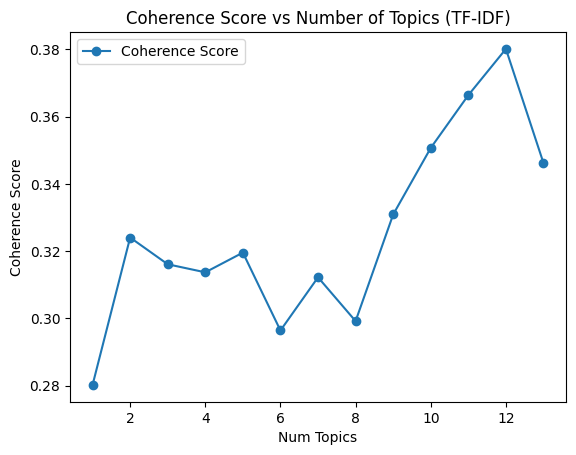

In [27]:
def compute_coherence_values(id2word, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        # Buat model LDA dengan corpus berbasis bow
        model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42, passes=10)
        model_list.append(model)

        # Hitung coherence score
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence = coherence_model.get_coherence()
        coherence_values.append(coherence)

    # Cari jumlah topik dengan coherence score tertinggi
    best_num_topics = start + coherence_values.index(max(coherence_values)) * step
    print(f"Jumlah topik optimal: {best_num_topics} dengan coherence score: {max(coherence_values)}")

    # Latih ulang model dengan jumlah topik terbaik
    best_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=best_num_topics, random_state=42, passes=10)

    return model_list, coherence_values, best_model

# Menentukan range jumlah topik
start = 1
limit = 13
step = 1

# Menjalankan evaluasi coherence menggunakan corpus berbasis bow
model_list, coherence_values, best_model = compute_coherence_values(
    id2word=id2word, 
    corpus=corpus_tfidf, 
    texts=preprocessed_texts, 
    start=start, 
    limit=limit + 1, 
    step=step
)

# Visualisasi coherence score
x = range(start, limit+1, step)
plt.plot(x, coherence_values, marker="o")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs Number of Topics (TF-IDF)")
plt.legend(["Coherence Score"], loc="best")
plt.show()

In [ ]:
# Tampilkan topik-topik yang dihasilkan
print("\nTopik yang dihasilkan:")
for idx, topic in best_model.print_topics(num_words=15):
    print(f"Topik {idx + 1}: {topic}")

lda_display = gensimvis.prepare(best_model, corpus_tfidf, id2word, sort_topics=False)
pyLDAvis.display(lda_display)

In [ ]:
# Tentukan jumlah topik dan grid layout
num_topics = 11
cols = 3 # Banyaknya word cloud per baris
rows = (num_topics // cols) + (num_topics % cols > 0)  # Hitung jumlah baris yang dibutuhkan

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))  # Atur ukuran grid

for i, ax in enumerate(axes.flatten()):  # Loop melalui subplot
    if i < num_topics:
        words = dict(best_model.show_topic(i, 25))  # Ambil 30 kata topik
        wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(words)
        
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f"Topik {i + 1}")
        ax.axis("off")
    else:
        ax.axis("off")  # Kosongkan subplot yang tidak terpakai jika jumlah topik kurang dari grid

plt.tight_layout()
plt.show()

# Hasil Penelitian

## Visualisasi Hasil Prediksi

distribusi data label yang dihasilkan model svm

In [15]:
df = pd.read_csv('revisi/predict1003_age.csv')
df.head()

age kategori_usia  rating  \
0  19 - 24        Remaja       5   
1  19 - 24        Remaja       5   
2  19 - 24        Remaja       4   
3  30 - 34  Dewasa Akhir       4   
4  25 - 29   Dewasa Awal       3   

                                        text_content  label  
0  Aku punya yang packaging nya mungil ( travel s...      1  
1  THIS IS ONE OF THE BEST & UNDERRATED SUNSCREEN...     -1  
2  Cepet ngeresap dan gampang diblend ga bikin mu...      1  
3  Teksturnya ringan, mudah diratakan, dan cepat ...      1  
4  Ini aku salah beli deh, ternyata lebih cocok u...     -1

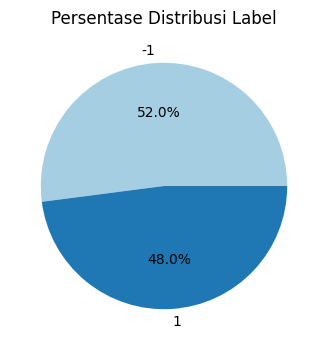

In [18]:
label_counts = df['label'].value_counts()

# Buat Pie Chart
plt.figure(figsize=(4, 4))
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title("Persentase Distribusi Label")

# Tampilkan plot
plt.show()

C:\Users\acer\AppData\Local\Temp\ipykernel_11460\3215621070.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette=plt.cm.Paired.colors)


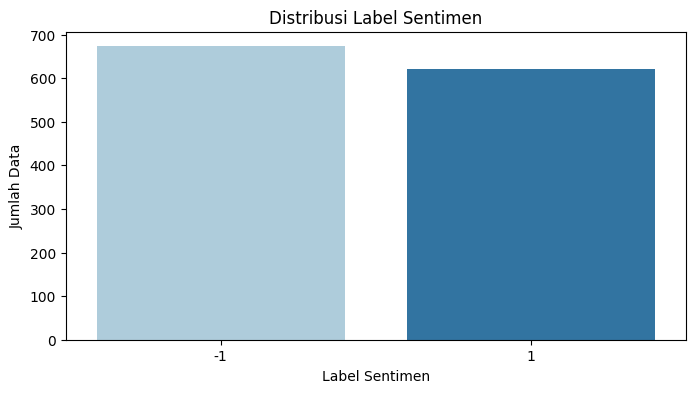

In [12]:
plt.figure(figsize=(8, 4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette=plt.cm.Paired.colors)

plt.xlabel("Label Sentimen")
plt.ylabel("Jumlah Data")
plt.title("Distribusi Label Sentimen")

plt.show()

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1293 entries, 0 to 1292
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   age            1293 non-null   object
 1   kategori_usia  1287 non-null   object
 2   rating         1293 non-null   int64 
 3   text_content   1293 non-null   object
 4   label          1293 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 50.6+ KB


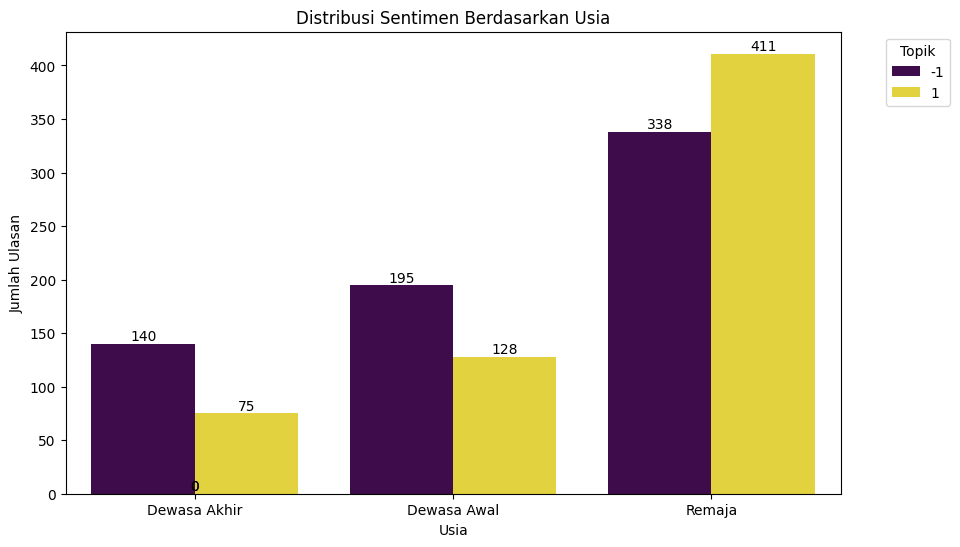

In [52]:
# Hitung jumlah ulasan per topik berdasarkan usia
df_count = df.groupby(["kategori_usia", "label"]).size().reset_index(name="count")

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="kategori_usia", y="count", hue="label", data=df_count, palette="viridis")

# Tambahkan label jumlah di atas setiap bar
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), ".0f"),  # Format angka tanpa desimal
        (p.get_x() + p.get_width() / 2., p.get_height()),  # Posisi teks
        ha="center", va="bottom", fontsize=10, color="black"
    )

# Label & Judul
plt.xlabel("Usia")
plt.ylabel("Jumlah Ulasan")
plt.title("Distribusi Sentimen Berdasarkan Usia")
plt.legend(title="Topik", bbox_to_anchor=(1.05, 1), loc="upper left")

# Tampilkan plot
plt.show()

## Visualisasi Topik

In [28]:
lda_display = gensimvis.prepare(lda_tfidf, corpus_tfidf, id2word, sort_topics=False)
pyLDAvis.display(lda_display)

c:\Users\acer\Envs\skilvul\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\acer\Envs\skilvul\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\acer\Envs\skilvul\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\acer\Envs\skilvul\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n
c:\Users\acer\Envs\skilvul\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isins

In [ ]:
pyLDAvis.save_html(lda_display, 'revisi/visualisasi.html')

visualisasi distribusi topik

In [ ]:
# Hitung jumlah ulasan per topik
topic_counts = neg_text['topic_number'].value_counts().sort_index()

# Buat visualisasi
plt.figure(figsize=(6, 2))
ax = sns.barplot(x=topic_counts.index, y=topic_counts.values, palette="viridis")

# Tambahkan label di atas setiap bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black')

# Tambahkan label sumbu
plt.xlabel("Nomor Topik")
plt.ylabel("Jumlah Ulasan")
plt.title("Distribusi Ulasan per Topik")
plt.xticks(topic_counts.index)

# Tampilkan plot
plt.show()


In [ ]:
# Data jumlah ulasan per topik
topik_labels = ["Topik 1", "Topik 2", "Topik 3", "Topik 4", "Topik 5"]
topik_counts = [111, 124, 67, 105, 266]  # Sesuai data yang diberikan

# Membuat pie chart
plt.figure(figsize=(5, 5))
plt.pie(topik_counts, labels=topik_labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
# plt.pie(topik_counts, labels=topik_labels, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis", len(topic_counts)))

# Menambahkan judul
plt.title("Distribusi Ulasan Berdasarkan Topik")

# Menampilkan plot
plt.show()

### analisa topik

Topik yang dihasilkan:
<br>Topik 1: 0.039*"abu" + 0.019*"sengat" + 0.014*"area" + 0.013*"rata" + 0.011*"basah" + 0.011*"ganti" + 0.010*"aroma" + 0.010*"kemas" + 0.010*"whitecast" + 0.009*"ambil"
<br>Topik 2: 0.028*"timpa" + 0.018*"simpel" + 0.017*"bedak" + 0.017*"berkomedo" + 0.016*"kemas" + 0.016*"stik" + 0.015*"usaha" + 0.015*"rias" + 0.015*"minyak" + 0.015*"sensasi"
<br>Topik 3: 0.027*"padat" + 0.015*"sunstick" + 0.013*"kecil" + 0.013*"bubuk" + 0.012*"benci" + 0.012*"gelap" + 0.010*"sisa" + 0.009*"kilap" + 0.008*"oles" + 0.008*"keluar"
<br>Topik 4: 0.015*"gaenak" + 0.011*"susu" + 0.010*"pengaruh" + 0.007*"keluar" + 0.007*"ganas" + 0.007*"timpa" + 0.006*"rias" + 0.006*"konsistensi" + 0.006*"buka" + 0.006*"berkomedo"
<br>Topik 5: 0.037*"gumpal" + 0.029*"harga" + 0.025*"aplikasi" + 0.022*"lekat" + 0.019*"mahal" + 0.019*"rata" + 0.017*"putih" + 0.017*"matte" + 0.017*"sukar" + 0.012*"panas"
<br>Topik 6: 0.015*"rias" + 0.013*"layer" + 0.009*"macet" + 0.009*"kelopak" + 0.008*"lekat" + 0.008*"merah" + 0.008*"foundie" + 0.007*"aplikasi" + 0.007*"tepuk" + 0.007*"gumpal"
<br>Topik 7: 0.045*"mata" + 0.042*"perih" + 0.027*"pedih" + 0.026*"beruntus" + 0.024*"panas" + 0.024*"sensitif" + 0.023*"jerawat" + 0.018*"keringat" + 0.015*"minyak" + 0.015*"putih"
<br>Topik 8: 0.015*"mata" + 0.010*"perih" + 0.009*"luntur" + 0.009*"matte" + 0.008*"aroma" + 0.008*"keren" + 0.008*"minyak" + 0.008*"losion" + 0.008*"lengket" + 0.008*"bedak"
<br>Topik 9: 0.031*"kemas" + 0.025*"susah" + 0.023*"whitecast" + 0.023*"rata" + 0.022*"kental" + 0.019*"keluar" + 0.018*"putih" + 0.017*"jerawat" + 0.016*"niacinamide" + 0.015*"tekstur"
<br>Topik 10: 0.043*"lama" + 0.039*"minyak" + 0.036*"kusam" + 0.036*"serap" + 0.032*"berat" + 0.031*"kering" + 0.026*"lembap" + 0.024*"tekstur" + 0.021*"encer" + 0.021*"whitecast"
<br>Topik 11: 0.051*"kecil" + 0.026*"tekan" + 0.013*"whitecast" + 0.013*"berat" + 0.011*"gatal" + 0.011*"keluar" + 0.010*"kemas" + 0.009*"mahal" + 0.009*"susah" + 0.009*"botol"
<br>Topik 12: 0.014*"jerawat" + 0.014*"pipi" + 0.011*"stik" + 0.010*"bawah" + 0.010*"fragrancenya" + 0.009*"rias" + 0.008*"harga" + 0.008*"lengket" + 0.008*"minyak" + 0.008*"kuat"

**interprestasi tiap topik**

Topik 1 (gabungan topik 1, 2, dan 5) **whitecast sulit diratakan dan sensasi menyengat**
<br>Pelanggan mengeluhkan bahwa sunscreen ini meninggalkan efek abu-abu dan whitecast yang sulit diratakan di area tertentu, terutama saat kulit dalam kondisi basah. Beberapa pengguna juga mengalami sensasi menyengat setelah pemakaian, yang membuat kulit terasa tidak nyaman. Kemasan produk dianggap kurang praktis karena sulit diambil dan dikeluarkan, sehingga pengguna perlu berusaha lebih saat mengaplikasikannya. Saat digunakan bersama bedak atau riasan lainnya, sunscreen ini cenderung menggumpal dan menyebabkan tampilan makeup tidak merata. Selain itu, meskipun memberikan hasil akhir matte, teksturnya terasa lengket, sulit dibaurkan, dan harganya dianggap terlalu mahal oleh sebagian pengguna.

Topik 2 (gabungan topik 3, 8, 11, dan 12) **risiko jerawat dan iritasi dari sunstick**
<br>Pelanggan mengeluhkan sunscreen berbentuk stik yang memiliki tekstur padat sehingga sulit diaplikasikan secara merata. Ukurannya yang kecil serta mekanisme yang membutuhkan tekanan lebih saat mengeluarkan produk membuat penggunaan terasa kurang praktis.Setelah diaplikasikan, produk ini meninggalkan residu bertekstur bubuk, terasa berat di kulit, dan menyebabkan whitecast, terutama pada pemilik kulit yang lebih gelap. Penggunaan dalam bentuk stik juga dinilai kurang higienis karena produk langsung bersentuhan dengan kulit, sehingga lebih berisiko menyebabkan jerawat di area pipi, terutama bagi kulit yang sensitif. Beberapa pengguna mengalami iritasi, seperti gatal, dan mata perih saat terkena keringat. Produk ini juga dinilai lengket, membuat kulit semakin berminyak, dan memiliki aroma yang terlalu kuat. Beberapa pelanggan merasa bahwa harga yang ditawarkan tidak sebanding dengan kualitasnya.

Topik 3 (4 dan 6) **tekstur tidak nyaman dan menggumpal saat dipadukan dengan riasan**
<br>Pelanggan mengeluhkan bahwa tekstur sunscreen yang menyerupai susu terasa tidak nyaman di kulit dan sulit diratakan. Produk ini juga sulit dikeluarkan dari kemasannya, sementara konsistensinya yang kurang baik berdampak pada tampilan riasan. Saat digunakan bersama makeup atau foundation, sunscreen cenderung menggumpal, sehingga menyulitkan proses layering. Selain itu, produk ini terasa lengket di kelopak mata, berpotensi menyebabkan komedo, dan pada beberapa pengguna, menimbulkan reaksi kemerahan setelah pemakaian.

Topik 4 (7) **luruh saat berkeringat dan iritasi mata**
<br>Pelanggan mengeluhkan bahwa sunscreen ini cenderung luruh saat berkeringat, sehingga tidak sengaja masuk ke mata dan menyebabkan rasa perih dan pedih. Pada kulit sensitif, produk ini juga dapat menimbulkan sensasi panas, memicu beruntusan dan jerawat, serta meninggalkan whitecast yang membuat kulit tampak lebih berminyak.

Topik 5 (9) **kemasan dengan pompa kurang praktis**
<br>Pelanggan mengeluhkan kemasan yang kurang praktis, di mana produk sulit dikeluarkan dari botol, dan pompa yang susah dikontrol sering kali menyebabkan sunscreen tumpah. Selain itu, teksturnya yang terlalu kental dan berat tidak hanya meninggalkan whitecast, tetapi juga menyebabkan jerawat

Topik 6 (10) **tekstur berat dan lama menyerap**
<br>Pelanggan mengeluhkan bahwa sunscreen memiliki tekstur yang berat, sehingga butuh waktu lama untuk menyerap. Hal ini menyebabkan wajah menjadi berminyak dan tampak kusam setelah pemakaian. Selain itu, sunscreen juga meninggalkan whitecast yang mengganggu tampilan kulit.

In [4]:
all = pd.read_csv('revisi/distribusitopik1603.csv')
all.head()

age kategori_usia  rating  \
0       19 - 24        Remaja       5   
1       25 - 29   Dewasa Awal       3   
2       25 - 29   Dewasa Awal       3   
3  18 and Under        Remaja       4   
4       25 - 29   Dewasa Awal       4   

                                        text_content  label  \
0  THIS IS ONE OF THE BEST & UNDERRATED SUNSCREEN...     -1   
1  Ini aku salah beli deh, ternyata lebih cocok u...     -1   
2  menurutku dengan harga yang lumayan agak price...     -1   
3  sunscreen pertama yang aku pakai saat mau nyob...     -1   
4  aku cobain travel sizenya sunscreen ini. kulit...     -1   

                                        text_cleaned  topic_number  topic  
0  ['lama', 'hapus', 'tekstur', 'krim', 'matte', ...             3      2  
1  ['minyak', 'kering', 'kemas', 'bubuk', 'kering...             3      2  
2  ['harga', 'mahal', 'whitecast', 'parah', 'abu'...             1      1  
3  ['whitecast', 'blend', 'tekstur', 'padat', 'ar...             7      4  
4  ['ribet', 'keren', 'matte', 'kecil', 'mahal', ...             8      2

In [5]:
all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 673 entries, 0 to 672
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   age            673 non-null    object
 1   kategori_usia  673 non-null    object
 2   rating         673 non-null    int64 
 3   text_content   673 non-null    object
 4   label          673 non-null    int64 
 5   text_cleaned   673 non-null    object
 6   topic_number   673 non-null    int64 
 7   topic          673 non-null    int64 
dtypes: int64(4), object(4)
memory usage: 42.2+ KB


C:\Users\acer\AppData\Local\Temp\ipykernel_4240\4062319634.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=topic_counts.index, y=topic_counts.values, palette="viridis")


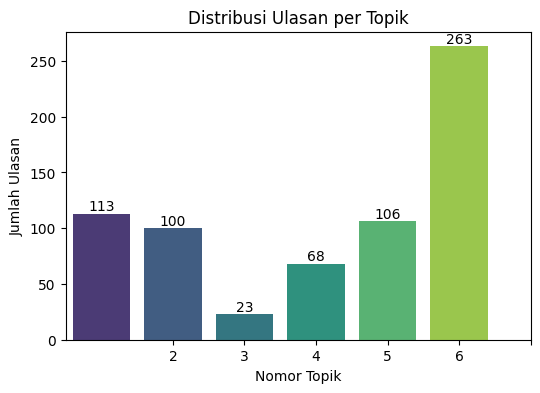

In [6]:
# Hitung jumlah ulasan per topik
topic_counts = all['topic'].value_counts().sort_index()

# Buat visualisasi
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=topic_counts.index, y=topic_counts.values, palette="viridis")

# Tambahkan label di atas setiap bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black')

# Tambahkan label sumbu
plt.xlabel("Nomor Topik")
plt.ylabel("Jumlah Ulasan")
plt.title("Distribusi Ulasan per Topik")
plt.xticks(topic_counts.index)

# Tampilkan plot
plt.show()


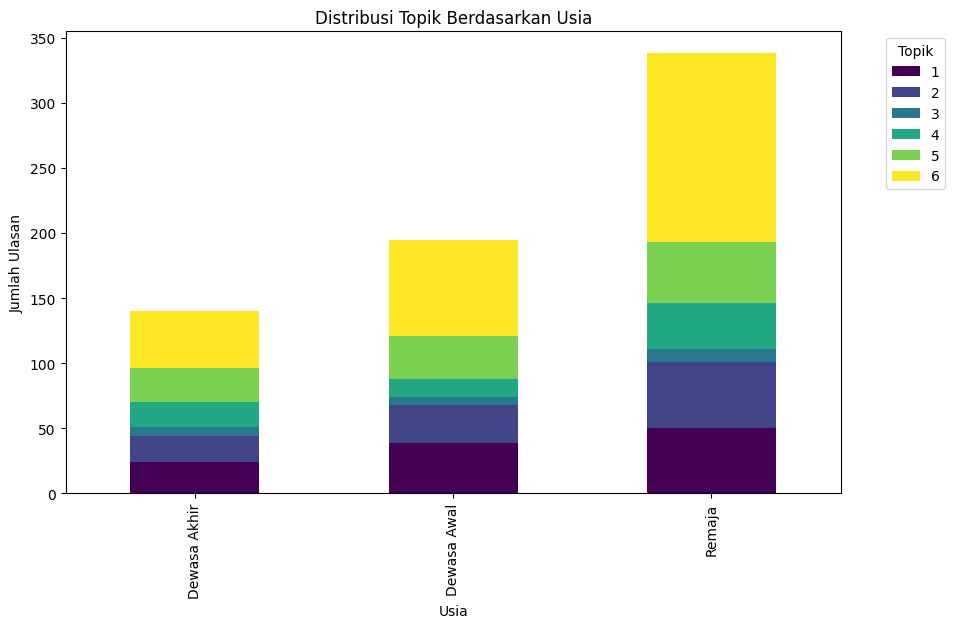

In [7]:
# Hitung jumlah ulasan per topik berdasarkan usia
pivot = all.pivot_table(index="kategori_usia", columns="topic", aggfunc="size", fill_value=0)

# Plot stacked bar chart
pivot.plot(kind="bar", stacked=True, cmap="viridis", figsize=(10, 6))

# Label & Judul
plt.xlabel("Usia")
plt.ylabel("Jumlah Ulasan")
plt.title("Distribusi Topik Berdasarkan Usia")
plt.legend(title="Topik", bbox_to_anchor=(1.05, 1), loc="upper left")

# Tampilkan plot
plt.show()

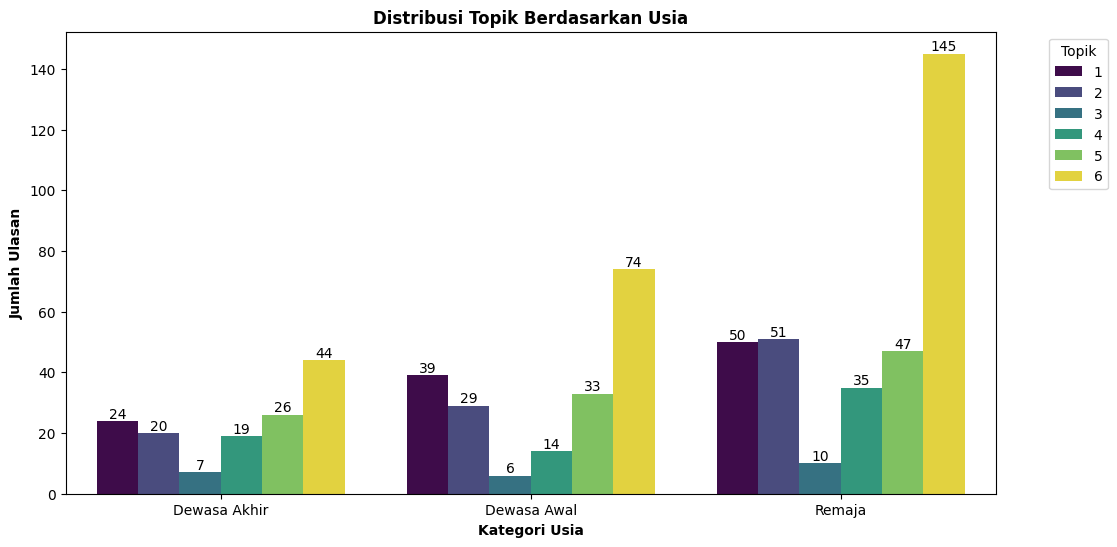

In [13]:
# Hitung jumlah ulasan per topik berdasarkan usia
if "kategori_usia" in all.columns and "topic" in all.columns:
    all_count = all.groupby(["kategori_usia", "topic"]).size().reset_index(name="count")
else:
    raise KeyError("DataFrame 'all' tidak memiliki kolom 'kategori_usia' atau 'topic'")

# Buat plot grouped bar chart
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="kategori_usia", y="count", hue="topic", data=all_count, palette="viridis")

# Tambahkan label jumlah di atas setiap bar
for p in ax.patches:
    height = p.get_height()
    if not pd.isna(height) and height > 0:  # Pastikan height valid
        ax.annotate(
            format(height, ".0f"),  # Format angka tanpa desimal
            (p.get_x() + p.get_width() / 2., height),  # Posisi teks
            ha="center", va="bottom", fontsize=10, color="black"
        )

# Label & Judul
plt.xlabel("Kategori Usia", fontweight="bold")
plt.ylabel("Jumlah Ulasan", fontweight="bold")
plt.title("Distribusi Topik Berdasarkan Usia", fontweight="bold")
plt.xticks(rotation=0)  # Pastikan label tetap horizontal
plt.legend(title="Topik", bbox_to_anchor=(1.05, 1), loc="upper left")

# Tampilkan plot
plt.show()

## pemodelan berdasarkan usia

In [ ]:
hasil_topik = pd.read_csv('revisi/ulasanhasil_age.csv')
hasil_topik.head()

In [ ]:
teenagers = hasil_topik[hasil_topik['age'] == '18 and Under']
teenagers.head()

In [ ]:
adult = hasil_topik[hasil_topik['age'] != '18 and Under']
adult.head()

In [ ]:
teenagers.shape

In [ ]:
adult.shape

In [ ]:
# Hitung jumlah ulasan per topik
topic_counts = teenagers['topic_number'].value_counts().sort_index()

# Buat visualisasi
plt.figure(figsize=(6, 2))
ax = sns.barplot(x=topic_counts.index, y=topic_counts.values, palette="viridis")

# Tambahkan label di atas setiap bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black')

# Tambahkan label sumbu
plt.xlabel("Nomor Topik")
plt.ylabel("Jumlah Ulasan")
plt.title("Distribusi Ulasan per Topik")
plt.xticks(topic_counts.index)

# Tampilkan plot
plt.show()

In [ ]:
# Hitung jumlah ulasan per topik
topic_counts = adult['topic_number'].value_counts().sort_index()

# Buat visualisasi
plt.figure(figsize=(6, 2))
ax = sns.barplot(x=topic_counts.index, y=topic_counts.values, palette="viridis")

# Tambahkan label di atas setiap bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black')

# Tambahkan label sumbu
plt.xlabel("Nomor Topik")
plt.ylabel("Jumlah Ulasan")
plt.title("Distribusi Ulasan per Topik")
plt.xticks(topic_counts.index)

# Tampilkan plot
plt.show()

## WordCloud

worldcloud untuk data label negatif

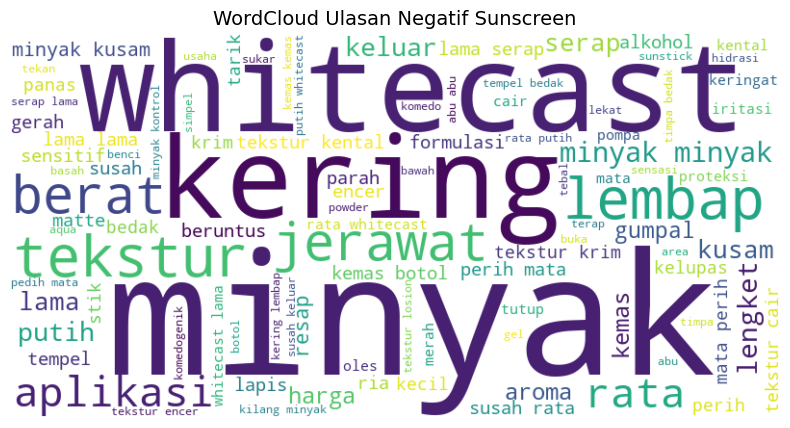

In [65]:
# Gabungkan semua kata dalam satu string
text_data = " ".join([" ".join(words) for words in neg_text['text_cleaned']])

# Buat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', 
                      max_words=100, random_state=42).generate(text_data)

# Plot WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Hilangkan sumbu
plt.title("WordCloud Ulasan Negatif Sunscreen", fontsize=14)
plt.show()

wordcloud untuk data label positif

In [70]:
post_text.shape

(620, 6)

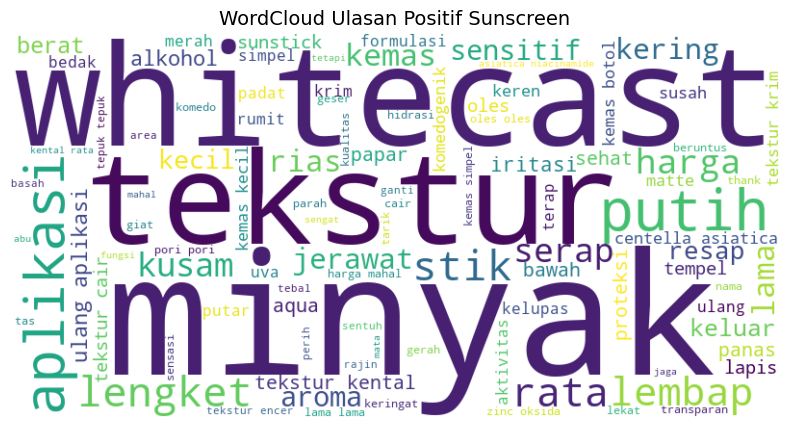

In [71]:
# Gabungkan semua kata dalam satu string
text_data = " ".join([" ".join(words) for words in post_text['text_cleaned']])

# Buat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', 
                      max_words=100, random_state=42).generate(text_data)

# Plot WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Hilangkan sumbu
plt.title("WordCloud Ulasan Positif Sunscreen", fontsize=14)
plt.show()

wordcloud untuk setiap topik

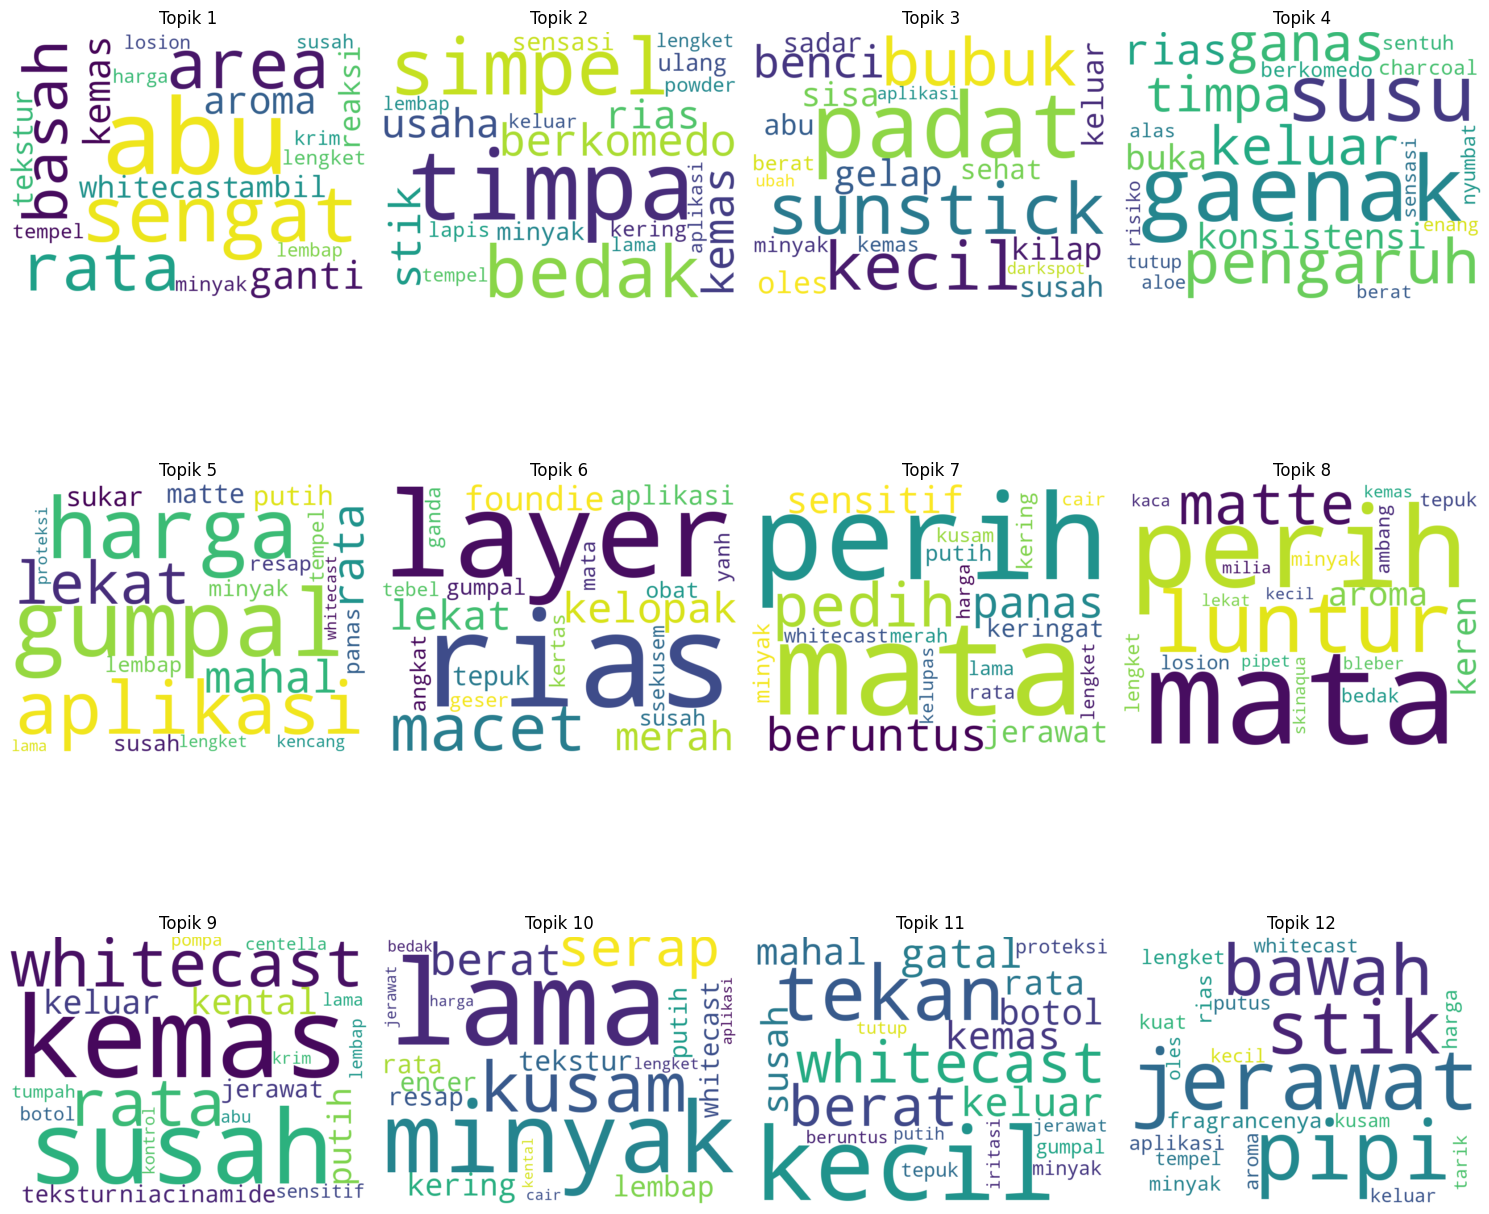

In [84]:
# Tentukan jumlah topik dan grid layout
num_topics = 12
cols = 4  # Banyaknya word cloud per baris
rows = (num_topics // cols) + (num_topics % cols > 0)  # Hitung jumlah baris yang dibutuhkan

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))  # Atur ukuran grid

for i, ax in enumerate(axes.flatten()):  # Loop melalui subplot
    if i < num_topics:
        words = dict(lda_tfidf.show_topic(i, 20))  # Ambil 30 kata topik
        wordcloud = WordCloud(width=800, height=600, background_color='white').generate_from_frequencies(words)
        
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f"Topik {i + 1}")
        ax.axis("off")
    else:
        ax.axis("off")  # Kosongkan subplot yang tidak terpakai jika jumlah topik kurang dari grid

plt.tight_layout()
plt.show()

# Hasil Klasifikasi dengan SVM

### Preprocessing Teks

In [ ]:
df = pd.read_csv('result/cleaned_data.csv')
df.head(2)

setelah melakukan tahapan prerpocessing case folding, hasilnya sebagai berikut:

In [ ]:
hasil_casefolding = df[['text_content', 'lowercased_text']]
pd.options.display.max_colwidth = 600
hasil_casefolding.head(1)


hasil case folding, yang telah disimpan pada kolom lowercased_text, selanjutnya diimplementasikan fungsi normalisasi yang kemudian menghasilkan data seperti berikut:

In [ ]:
hasil_normalisasi = df[['lowercased_text', 'normalized_text']]
pd.options.display.max_colwidth = 600
hasil_normalisasi.head(1)

teks yang sudah melalui tahapan normalisasi selanjutnya akan dilakukan pembersihan karakter-karakter serta stopwords yang tidak dibutuhkan untuk proses klasifikasi. daftar stopwords didapatkan dari library Sastrawi serta membuat daftar stopwords secara mandiri, dua daftar ini kemudian akan digabungkan untuk memperkaya list stopwords yang perlu dihapus.

In [ ]:
hasil_filtering = df[['normalized_text', 'filtered_text']]
pd.options.display.max_colwidth = 600
hasil_filtering.head(1)

selanjutnya, teks yang sudah dibersihkan akan dijadikan dalam bentuk token untuk mempermudah pemrosesan analisis

In [ ]:
hasil_tokenisasi = df[['filtered_text', 'tokens']]
pd.options.display.max_colwidth = 600
hasil_tokenisasi.head(1)

setelah melakukan tokenisasi, akan dilakukan proses stemming untuk menghilangkan imbuhan dan mengembalikan kata menjadi bentuk dasar

In [ ]:
hasil_stemming = df[['tokens', 'stemmed_text']]
pd.options.display.max_colwidth = 600
hasil_stemming.head(1)

### Evaluasi Model

Pelatihan data klasifikasi dilakukan menggunakan model Support Vector Machine menggunakan kernel non-linier Radial Basis Function dengan nilai pada parameter Complexity = 1 dan gamma = 0,2.

In [ ]:
y_pred = svm.predict(X_test_tfidf) # prediksi data text (X_test)

accuracy = accuracy_score(y_test, y_pred) # evaluasi performa model pada data uji
report = classification_report(y_test, y_pred)

print(f"\nFinal Model Test Accuracy without CV: {accuracy:.4f}")
print("Classification Report:\n", report)

confussion matrix

In [ ]:
# menghitung confusion matrix
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cm)

# visualisasi confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix")
plt.show()

Dilakukan prediksi label terhadap data awal sebelum dilakukan pembersihan akan menggunakan model SVM yang telah disimpan. Prediksi ini menghasilkan ulasan berlabel positif sebanyak 679 dan ulasan berlabel negatif sebanyak 709.

In [ ]:
label_counts = df['label'].value_counts()

# Buat Pie Chart
plt.figure(figsize=(4, 4))
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title("Persentase Distribusi Label")

# Tampilkan plot
plt.show()

# Hasil Pemodelan Topik

In [14]:
all = pd.read_csv('revisi/distribusitopik1603.csv')
all.head()

age kategori_usia  rating  \
0       19 - 24        Remaja       5   
1       25 - 29   Dewasa Awal       3   
2       25 - 29   Dewasa Awal       3   
3  18 and Under        Remaja       4   
4       25 - 29   Dewasa Awal       4   

                                        text_content  label  \
0  THIS IS ONE OF THE BEST & UNDERRATED SUNSCREEN...     -1   
1  Ini aku salah beli deh, ternyata lebih cocok u...     -1   
2  menurutku dengan harga yang lumayan agak price...     -1   
3  sunscreen pertama yang aku pakai saat mau nyob...     -1   
4  aku cobain travel sizenya sunscreen ini. kulit...     -1   

                                        text_cleaned  topic_number  topic  
0  ['lama', 'hapus', 'tekstur', 'krim', 'matte', ...             3      2  
1  ['minyak', 'kering', 'kemas', 'bubuk', 'kering...             3      2  
2  ['harga', 'mahal', 'whitecast', 'parah', 'abu'...             1      1  
3  ['whitecast', 'blend', 'tekstur', 'padat', 'ar...             7      4  
4  ['ribet', 'keren', 'matte', 'kecil', 'mahal', ...             8      2

## Analisa Topik

**Interprestasi Tiap Topik**

Topik 1 (gabungan topik 1, 2, dan 5) **whitecast sulit diratakan dan sensasi menyengat**
<br>Konsumen mengeluhkan bahwa sunscreen ini meninggalkan efek abu-abu
dan whitecast yang sulit diratakan di area tertentu, terutama saat kulit dalam
kondisi basah. Beberapa konsumen juga mengalami sensasi menyengat setelah
pemakaian, yang membuat kulit tidak nyaman. Kemasan produk dianggap
kurang praktis karena sulit diambil dan dikeluarkan, sehingga pengguna perlu
berusaha lebih saat mengaplikasikannya. Saat digunakan bersama bedak atau
riasan lainnya, produk cenderung menggumpal dan menyebabkan tampilan
make up tidak merata. Selain itu, meskipun memberikan hasil akhir matte,
teksturnya terasa lengket, sulit dibaurkan, dan harganya dianggap terlalu mahal
oleh sebagian konsumen. Dari deskripsi tersebut maka dapat disimpulkan topik
1 merupakan keluhan konsumen mengenai whitecast, sulit diratakan, dan
sensasi menyengat setelah penggunaan produk.

Topik 2 (gabungan topik 3, 8, 11, dan 12) **risiko jerawat dan iritasi dari sunstick**
<br>Konsumen mengeluhkan sunscreen berbentuk stik yang memiliki tekstur
padat sehingga sulit diaplikasikan secara merata. Ukurannya yang kecil serta
mekanisme yang membutuhkan tekanan lebih saat mengeluarkan produk
membuat pengguna merasa kurang praktis. Setelah diaplikasikan, produk ini
meninggalkan residu seperti bubuk di permukaan kulit, terasa berat sehingga
menyebabkan whitecast terutama pada kulit yang dengan tone lebih gelap.
Penggunaan sunscreen dalam bentuk stik juga dinilai kurang higienis karena
produk langsung bersentuhan dengan kulit, sehingga lebih berisiko menyebabkan jerawat terutama di area pipi bagi kulit sensitive. Bebepara
konsumen mengalami iritasi, seperti gatal, dan mata perih saat terkena keringat.
Tektur produk dinilai terlalu lengket yang membuat kulit semakin berminyak,
dan memilki aroma yang terlalu kuat. Konsumen juga merasa bahwa harga
yang ditawarkan tidak sebanding dengan kualitas yang dinilai cukup buruk.
Dari deskripsi tersebut maka dapat disimpulkan bahwa di topik 2 keluhan yang
disampaikan yaitu mengenai resiko jerawat dan iritasi dari sunscreen kemasan
sunstick.

Topik 3 (4 dan 6) **tekstur tidak nyaman dan menggumpal saat dipadukan dengan riasan**
<br>Konsumen mengeluhkan bahwa tekstur sunscreen yang terlalu cair seperti
susu terasa tidak nyaman di kulit dan sulit diratakan. Produk dengan tekstur ini
juga sulit dikeluarkan karena berisiko tumpah dan mengotori area tutup
kemasan. Selain itu, konsistensinya kurang baik saat digunakan bersama
riasan, karena sunscreen cenderung menggumpal sehingga menyulitkan proses
layering. Beberapa konsumen juga mengeluhkan rasa lengket di sekitar mata,
munculnya reaksi kemerahan setelah pemakaian, serta potensi penyumbatan
pori-pori yang dapat menyebabkan komedo. Dari deskripsi tersebut maka dapat
disimpulkan bahwa pada topik 3 keluhan yang dibahas yaitu mengenai tekstur
yang tidak nyaman dan menggumpal saat dipadukan dengan riasan.

Topik 4 (7) **luruh saat berkeringat dan iritasi mata**
<br>Konsumen mengeluhkan bahwa sunscreen cenderung luruh saat
berkeringat, sehingga tidak sengaja masuk ke mata dan menyebabkan rasa
perih dan pedih. Pada kulit sensitif, produk juga menimbulkan sensasi panas,
memicu beruntusan dan jerawat, serta meninggalkan whitecast yang membuat
kulit tampak lebih berminyak. Dari deskripsi tersebut, dapat diambil
kesimpulan bahwasannya keluhan yang ada pada topik 4 itu mengenai tekstur
yang luruh saat berkeringat dan menyebabkan iritasi mata.

Topik 5 (9) **kemasan dengan pump kurang praktis**
<br>Konsumen mengeluhkan kemasan yang kurang praktis, di mana produk
sulit dikeluarkan dari botol, dan pompa yang susah dikontrol sering kali
menyebabkan sunscreen tumpah. Selain itu, teksturnya yang terlalu kental dan
berat tidak hanya meninggalkan whitecast, tetapi juga menyebabkan jerawat.
Dari deskripsi ini, maka dapat diambil kesimpulan bahwasannya keluhan yang
disampaikan pada topik 5 yaitu mengenai kemasan botol dengan pompa dinilai
kurang praktis.

Topik 6 (10) **tekstur berat dan lama menyerap**
<br>Konsumen mengeluhkan sunscreen memiliki tekstur yang berat, sehingga
butuh waktu lama untuk menyerap. Hal ini menyebabkan wajah menjadi
berminyak dan tampak kusam setelah pemakaian. Selain itu, sunscreen juga
meninggalkan whitecast yang mengganggu tampilan kulit. Dari deskripsi
tersebut, maka dapat disimpulkan bahwa keluhan yang disampaikan pada topik
6 yaitu mengenai tekstur berat dan lama untuk menyerap.


## Visualisasi Topik

C:\Users\acer\AppData\Local\Temp\ipykernel_4240\1822715052.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=topic_counts.index, y=topic_counts.values, palette="viridis")


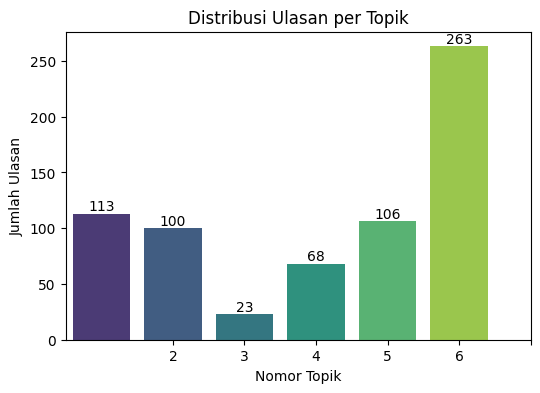

In [15]:
# Hitung jumlah ulasan per topik
topic_counts = all['topic'].value_counts().sort_index()

# Buat visualisasi
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=topic_counts.index, y=topic_counts.values, palette="viridis")

# Tambahkan label di atas setiap bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black')

# Tambahkan label sumbu
plt.xlabel("Nomor Topik")
plt.ylabel("Jumlah Ulasan")
plt.title("Distribusi Ulasan per Topik")
plt.xticks(topic_counts.index)

# Tampilkan plot
plt.show()

In [60]:
df = pd.read_csv('revisi/cleaneddata1803.csv')

In [62]:
df.shape

(1293, 6)

In [64]:
df['age'].value_counts()

age
19 - 24         637
25 - 29         323
30 - 34         157
18 and Under    112
35 - 39          43
40 - 44          11
No Age            6
45 and Above      4
Name: count, dtype: int64

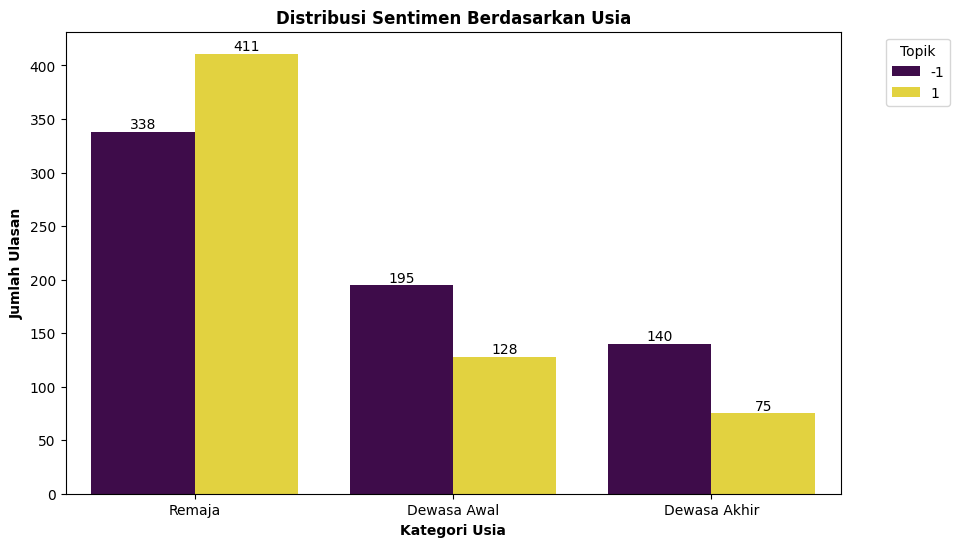

In [61]:
# Hitung jumlah ulasan per kategori usia & label
df_count = df.groupby(["kategori_usia", "label"]).size().reset_index(name="count")

# Pastikan semua kombinasi kategori usia & label ada
usia_unique = df["kategori_usia"].unique()
label_unique = df["label"].unique()

# Buat DataFrame referensi dengan semua kombinasi kategori usia & label
df_ref = pd.MultiIndex.from_product(
    [["Remaja", "Dewasa Awal", "Dewasa Akhir"], label_unique], 
    names=["kategori_usia", "label"]
).to_frame(index=False)

df_count = df_ref.merge(df_count, on=["kategori_usia", "label"], how="left").fillna(0)

# Pastikan kolom 'count' bertipe integer
df_count["count"] = df_count["count"].astype(int)

# Atur urutan kategori usia agar sesuai dengan yang diinginkan
df_count["kategori_usia"] = pd.Categorical(df_count["kategori_usia"], 
                                           categories=["Remaja", "Dewasa Awal", "Dewasa Akhir"], 
                                           ordered=True)

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="kategori_usia", y="count", hue="label", data=df_count, palette="viridis")

# Tambahkan label jumlah di atas setiap bar, hanya jika count > 0
for p in ax.patches:
    if p.get_height() > 0:  # Cegah label angka 0
        ax.annotate(
            format(p.get_height(), ".0f"),  # Format angka tanpa desimal
            (p.get_x() + p.get_width() / 2., p.get_height()),  # Posisi teks
            ha="center", va="bottom", fontsize=10, color="black"
        )

# Label & Judul
plt.xlabel("Kategori Usia", fontweight="bold")
plt.ylabel("Jumlah Ulasan", fontweight="bold")
plt.title("Distribusi Sentimen Berdasarkan Usia", fontweight="bold")
plt.legend(title="Topik", bbox_to_anchor=(1.05, 1), loc="upper left")

# Tampilkan plot
plt.show()

Pada grafik distribusi sentimen berdasarkan usia di atas, menunjukkan distribusi sentimen Berdasarkan kategori usia, yaitu remaja, dewasa awal, dan dewasa akhir. Hasil prediksi SVM menunjukkan bahwa kategori usia remaja paling mendominasi dengan jumlah ulasan terbanyak. Pada kelompok remaja, ulasan berlabel negatif berjumlah 338,
sedangkan ulasan berlabel positif berjumlah 411. Hal ini mengindikasikan bahwa
remaja cenderung lebih banyak memberikan ulasan positif dibandingkan negatif.
Sementara itu, pada kategori usia dewasa awal ulasan berlabel positif berjumlah 128, sedangkan ulasan berlabel negatif berjumlah 195. Meskipun jumlah ulasan negatif lebih tinggi daripada positif, secara keseluruhan jumlah ulasan dewasa awal lebih sedikit dibandingkan remaja. Untuk kategori usia dewasa akhir, ulasan berlabel positif berjumlah 75, sedangkan ulasan berlabel negatif berjumlah 140. Kelompok dewasa akhir memiliki jumlah ulasan paling sedikit dibandingkan dua kategori usia lainnya, dengan pola sentimen cenderung lebih negatif.

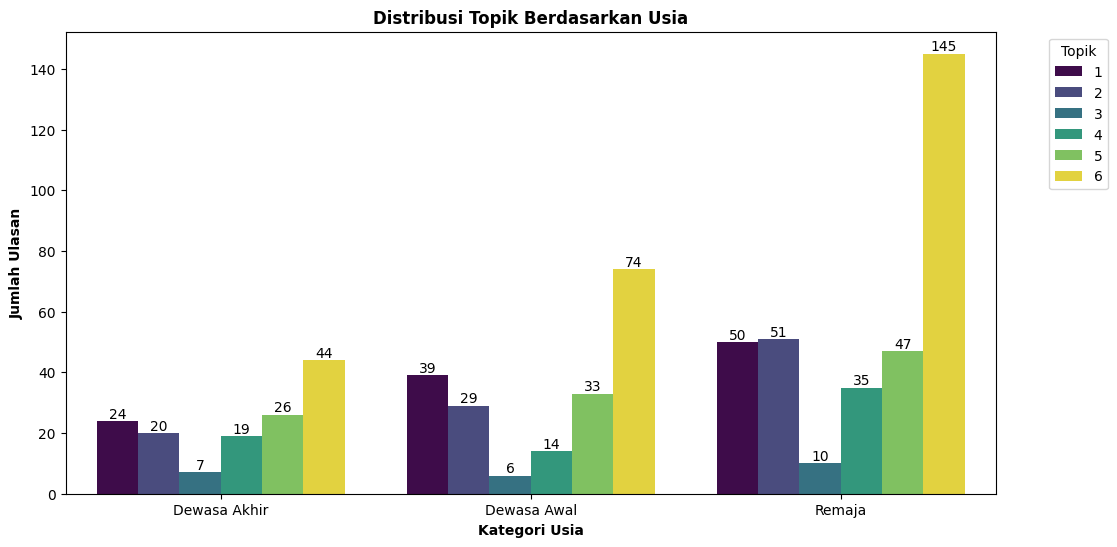

In [16]:
# Hitung jumlah ulasan per topik berdasarkan usia
if "kategori_usia" in all.columns and "topic" in all.columns:
    all_count = all.groupby(["kategori_usia", "topic"]).size().reset_index(name="count")
else:
    raise KeyError("DataFrame 'all' tidak memiliki kolom 'kategori_usia' atau 'topic'")

# Buat plot grouped bar chart
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="kategori_usia", y="count", hue="topic", data=all_count, palette="viridis")

# Tambahkan label jumlah di atas setiap bar
for p in ax.patches:
    height = p.get_height()
    if not pd.isna(height) and height > 0:  # Pastikan height valid
        ax.annotate(
            format(height, ".0f"),  # Format angka tanpa desimal
            (p.get_x() + p.get_width() / 2., height),  # Posisi teks
            ha="center", va="bottom", fontsize=10, color="black"
        )

# Label & Judul
plt.xlabel("Kategori Usia", fontweight="bold")
plt.ylabel("Jumlah Ulasan", fontweight="bold")
plt.title("Distribusi Topik Berdasarkan Usia", fontweight="bold")
plt.xticks(rotation=0)  # Pastikan label tetap horizontal
plt.legend(title="Topik", bbox_to_anchor=(1.05, 1), loc="upper left")

# Tampilkan plot
plt.show()

Pada grafik distribusi topik berdasarkan usia di atas, menunjukkan distribusi 6 ttopik keluhan terhadap sunscreen lokal berdasarkan kategori usia konsumen. Data usia dikelompokkan menjadi tiga, yaitu dewasa akhir (≥30 tahun), dewasa awal (25-29 tahun), dan remaja (≤24 tahun). Kategori remaja memiliki jumlah ulasan tertinggi, dengan dominasi keluhan pada topik 6 (tekstur berat dan lama menyerap) sebanyak 145 ulasan. Hal ini menunjukkan bahwa remaja lebih banyak mengeluhkan sunscreen yang terasa berat dan sulit menyerap di kulit. Keluhan ini bisa diartikan sebagai preferensi remaja terhadap produk yang ringan, cepat menyerap, dan nyaman digunakan sehati-hari, terutama dalam aktivitas outdoor. Remaja yang sering terlibat aktivitas outdoor seperti sekolah, olahraga, atau kegiatan sosial, membutuhka sunscreen yang tidak hanya memberikan perlindungan tetapi juga nyaman digunakan sepanjang hari. Oleh karena itu, tekstur yang berat dan lama menyerap menjadi keluhan utama, karena dianggap mengganguu kenyamanan dan penampilan.
<br>Selain itu, keluhan yang cukup banyak dibicarakan di kalangan remaja yaitu mengenai topik 2 dengan jumlah 51 ulasan. Pada topik ini konsumen mengeluhkan
bahwa penggunaan sunstick berpotensi menyebabkan jerawat dan iritasi, selain karena teksturnya padat juga karena penggunaannya yang langsung diaplikasikan ke kulit wajah. Hal ini bisa disebabkan karena kulit remaja yang masih sensitif, di mana kulit mereka cenderung lebih rentan terhadap jerawat karena aktivitas hormon yang tinggi sehingga produk yang kurang cocok atau kurang higienis dapat memicu masalah kulit. Sunstick yang langsung bersentuhan dengan kulit wajah juga berisiko menjadi sarang bakteri jika tidak dibersihkan secara rutin. Hal ini dapat
memperburuk kondisi kulit remaja yang sudah rentan terhadap jerawat dan iritasi. Jerawat juga umumnya muncul akibat pori-pori yang tersumbat, yang dapat disebabkan oleh produksi minyak berlebihan dan penggunaan produk dengantekstur produk yang lengket dan berat pada kulit (Dewi dkk, 2024).
<br>Dengan demikian penting bagi produsen untuk mempertimbangkan formulasi yang lebih ringan dan cepat menyerap agar sesuai dengan preferensi remaja yang menginginkan produk praktis dan nyaman digunakan sehari-hari. Formula yang lebih bersahabat dengan kulit sensitif untuk mengurangi resiko iritasi dan jerawat, serta kemasan yang lebih higienis seperti airless tube atau kemasan lain yang penggunaannya tidak langsung menyentuh kulit, terutama jika brand menyasar segmentasi remaja. Kategori dewasa awal (25-29 tahun) juga memiliki keluhan tertinggi pada
topik 6, dengan jumlah ulasan sebanyak 74. Kondisi ini menunjukkan bahwa keluhan terhadap tekstur sunscreen yang berat dan lama menyerap tidak hanya dialami oleh remaja, tetapi juga menjadi perhatian juga bagi konsumen dewasa awal. Kelompok usia ini cenderung mencari produk yang nyaman digunakan sehari-hari, terutama karena mereka sering menggunakan sunscreen di bawah makeup atau dalam bekerja. Tekstur yang berat dan lama menyerap akan cukup mengganggu kenyamanan dan penampilan terutama dalam situasi formal. 
<br>Selain itu, keluhan pada topik 1 (Whitecast sulit diratakan dan sensasi menyengat) juga cukup menonjol dengan 39 ulasan, yang menunjukkan bahwa tekstur dan hasil akhir (finishing) produk menjadi aspek yang diperhatikan oleh kelompok usia ini. Jika dilihat dari interpretasi yang telah dipaparkan sebelumnya, konsumen mengeluhkan bahwa sunscreen lokal meninggalkan efek abu-abu dan whitecast yang sulit diratakan. Selain itu, saat digunakan bersama riasan lainnya, sunscreen cenderung menggumpal dan menyebabkan tampilan makeup yang tidak merata. Masalah ini menjadi perhatian serius karena melihat bahwa kelompok usia ini sering menggunakan sunscreen sebagai bagian dari rutinitas makeup sehari-hari.
Dengan demikian, penting bagi produsen untuk mempertimbangkan formulasi yang lebih ringan, cepat menyerap, dan tidak meninggalkan whitecast serta menghindari bahan yang menyebabkan sensasi menyengat. Untuk menghindari sensasi menyengat pada kulit, produsen dapat mengurangi penggunaan alcohol dan paraben, dan menggantinya dengan bahan yang lebih ramah bagi kulit seperti ekstrak alami atau bahan pelembab hyaluronic acid untuk meningkatkan hidrasi dan kenyamanan pada kulit.
<br>Kategori dewasa akhir (≥30 tahun) memiliki jumlah ulasan paling sedikit dibandingkan dua kategori usia lainnya, tetapi tetap menunjukkan pola keluhan yang mirip. Keluhan yang paling dominan yaitu sama seperti dua kelompok sebelumnya, topik 6. Hal ini menunjukkan bahwa masalah tekstur sunscreen yang berat dan sulit menyerap juga menjadi perhatian bagi konsumen dewasa akhir. Kelompok dewasa akhir lebih memperhatikan kenyamanan penggunaan, terutama karena mereka cenderung memilih produk yang praktis namun efektif untuk mengatasi tanda-tanda penuaan. Tekstur yang berat dan lama menyerap akan sangat mengganggu kenyamanan dan efisiensi penggunaan. Selain itu, keluhan yang cukup tinggi juga terdapat pada topik 5 (kemasan dengan pump kurang praktis) dengan 26 ulasan. Hal ini menunjukkan bahwa bagi kelompok konsumen ini aspek kemudahan penggunaan produk menjadi perhatian yang lebih penting. Dewasa akhir cenderung lebih menyukai produk yang mudah digunakan dan efisien, terutama karena rutinitas atau kegiatan mereka yang padat. Kelompok ini lebih memilih kemasan yang praktis dan tidak rumit seperti tube yang pengaplikasiannya tinggal dipencet, atau kemasan airless pump yang memudahkan pengambilan produk tanpa perlu usaha ekstra. Kemasan yang mudah digunakan tidak hanya meningkatkan kepuasan konsumen tetapi juga memastikan produk dapat diaplikasikan dengan cepat dan efisien.
<br>Dengan demikian, penting bagi produsen untuk mempertimbangkan formulasi yang lebih ringat, cepat menyerap, dan tidak meninggalkan whitecast, serta kemasan yang lebih praktis dan mudah digunakan. Hal ini akan memenuhi kebutuhan kelompok usia dewasa akhir yang menginginkan produk yang efektif, nyaman, dan sesuai dengan gaya hidup mereka yang sibuk. Secara keseluruhan, hasil distribusi menunjukkan bahwa keluhan tekstur berat dan lama menyerap menjadi perhatian utama di semua kalangan umur, dengan intensitas tertinggi pada kelompok remaja dan dewasa awal.